In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# The goal
The main goal of this notebook is to perform deep data analysis and feature/data engineering, modeling part and results are secondary objective

This is not my first notebook on that problem - but i will paste previous one to here ( i am still proud of it) and make it even better with help of other reasources and other notebooks to learn more!

# Ride plan
1. Deep data analysis 
2. Modeling


In [2]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Tools 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import mean_squared_error # NOT root!
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import StackingRegressor

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchmetrics
import torch.optim as optim


# 1. Data Analysis

Data dictionary 
* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [4]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Based on above, we can see that not all data are not in numeric format - we have to deal with that later on


In [6]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


#### Before proceeding any further we have to split our data into trining and test set - that will prevent data snooping bias

In [7]:
train_data, validation_data = train_test_split(data, test_size=0.2,random_state=42)


In [8]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(train_data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,NaN,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


In [9]:
# Missing values in %
missing_values = train_data.isna().sum()
missing_columns = (missing_values[missing_values > 0] / len(train_data)) * 100
print(missing_columns.sort_values(ascending=False))

PoolQC          99.486301
MiscFeature     96.061644
Alley           93.664384
Fence           80.051370
MasVnrType      58.476027
FireplaceQu     46.832192
LotFrontage     18.578767
GarageType       5.479452
GarageYrBlt      5.479452
GarageFinish     5.479452
GarageQual       5.479452
GarageCond       5.479452
BsmtFinType1     2.397260
BsmtFinType2     2.397260
BsmtExposure     2.397260
BsmtCond         2.397260
BsmtQual         2.397260
MasVnrArea       0.513699
Electrical       0.085616
dtype: float64


We clearly see that features like `PoolQ`, `MiscFeature` ,`Alley`, `Fence`, `MasVnrType` , `FireplaceQu` ,`LotFrontage` has a lot of missing values. We can check how those missing values influence target variable `SalePrice`  

In [10]:
def missing_value_influance_on_target(data, variable):
    data = data.copy()
    
    data[variable] = np.where(data[variable].isnull(),1,0)
    
    temp = data.groupby(variable)["SalePrice"].agg(["mean", "std"])
    
    temp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Sale Price", color='green')
    plt.show()

In [11]:
def zero_value_influance_on_target(data, variable):
    data = data.copy()
    
    data[variable] = np.where(data[variable]==0,1,0)
    
    temp = data.groupby(variable)["SalePrice"].agg(["mean", "std"])
    
    temp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title="Sale Price", color='green')
    plt.show()

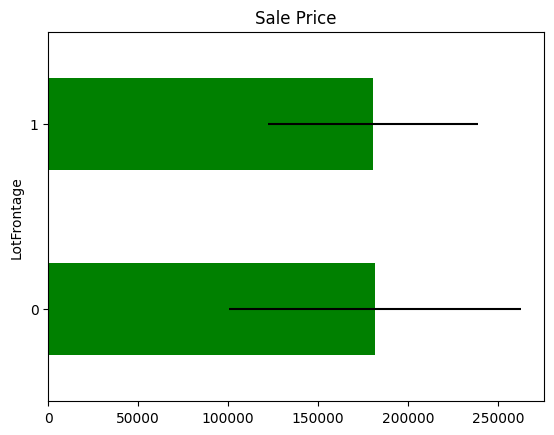

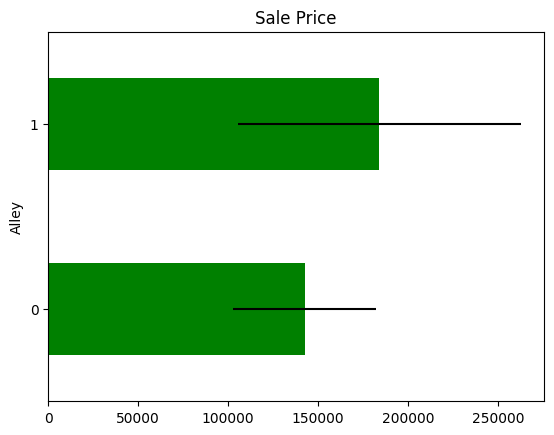

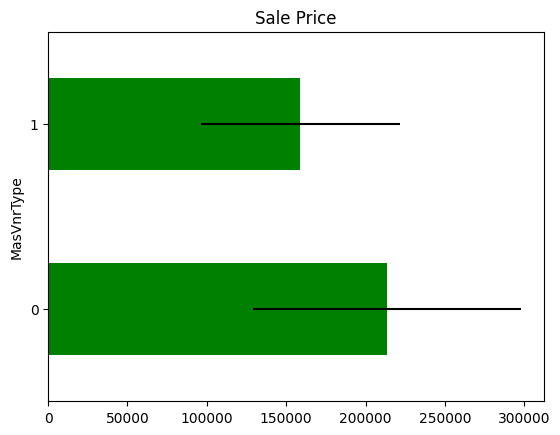

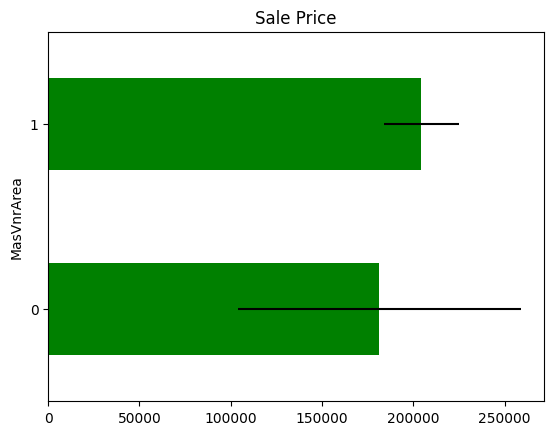

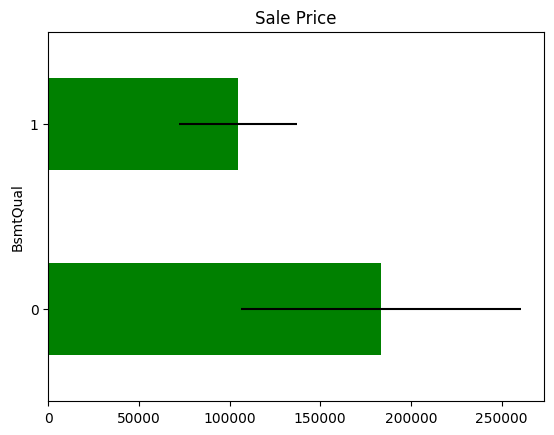

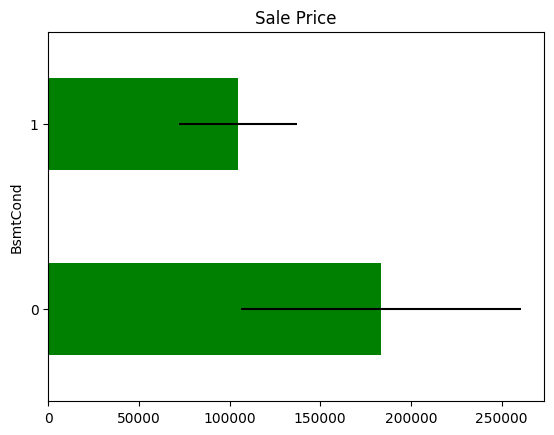

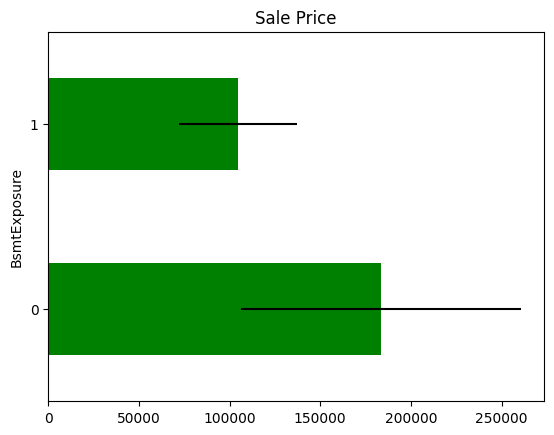

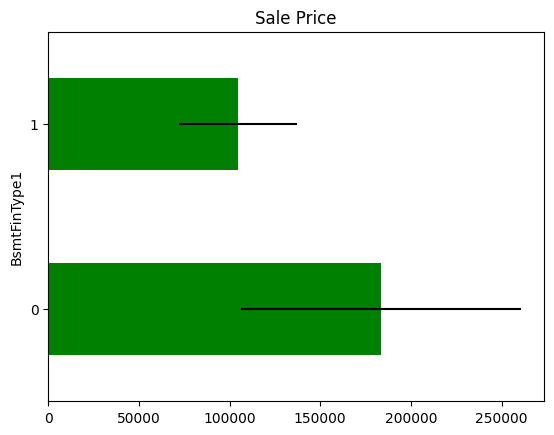

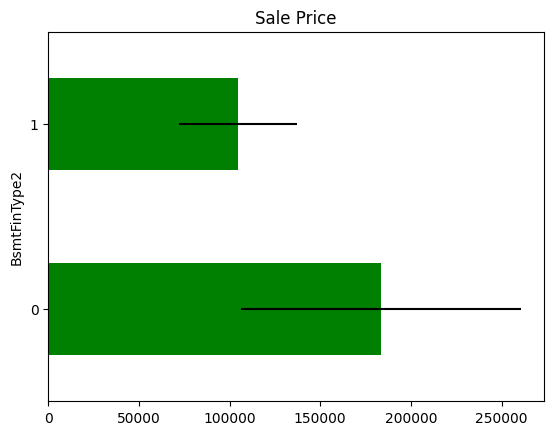

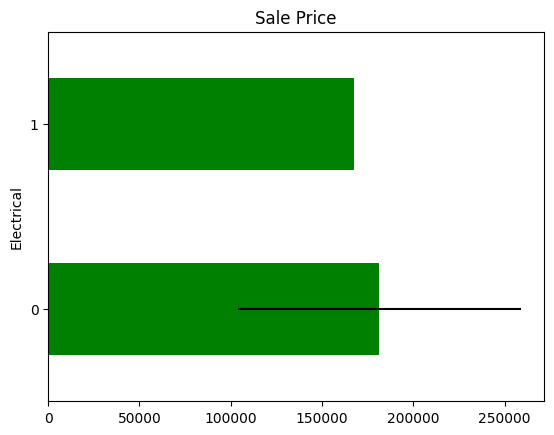

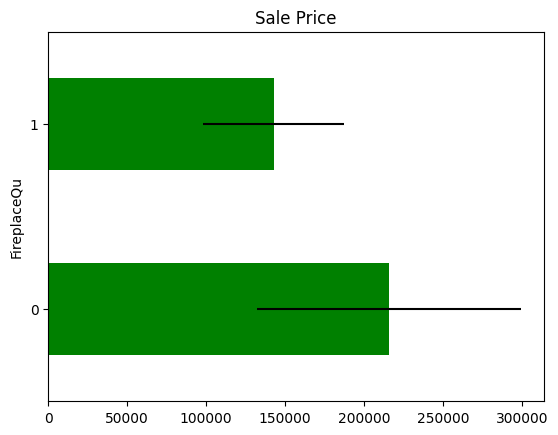

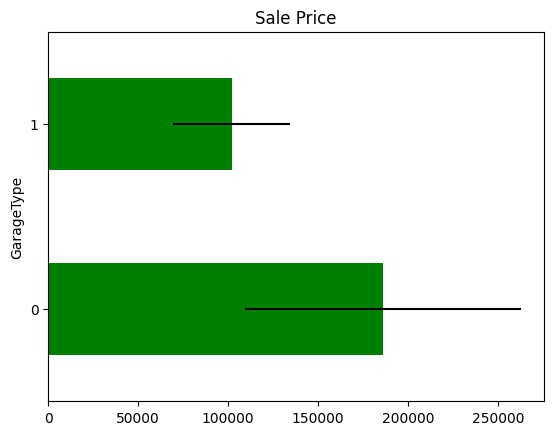

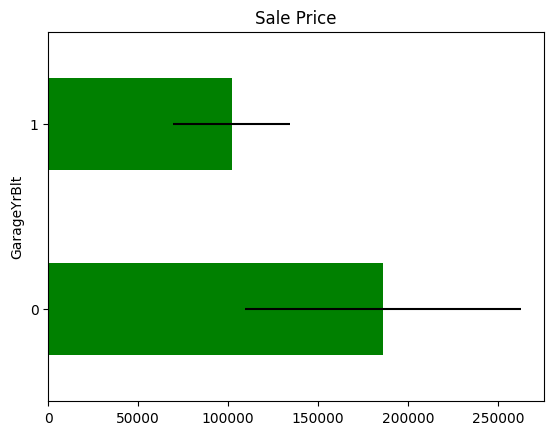

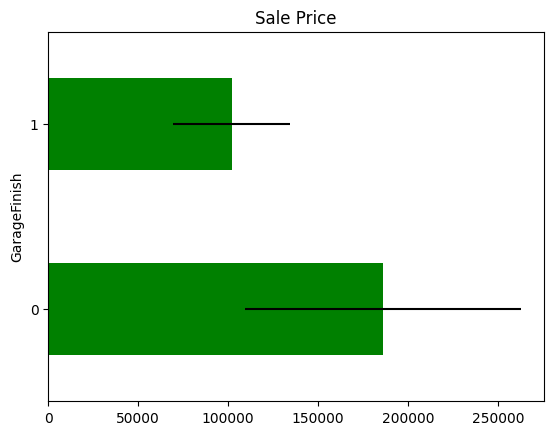

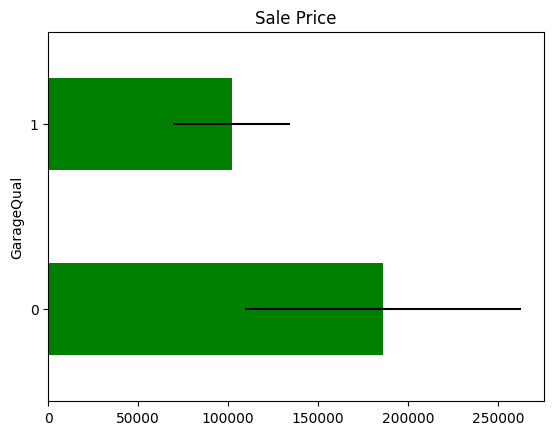

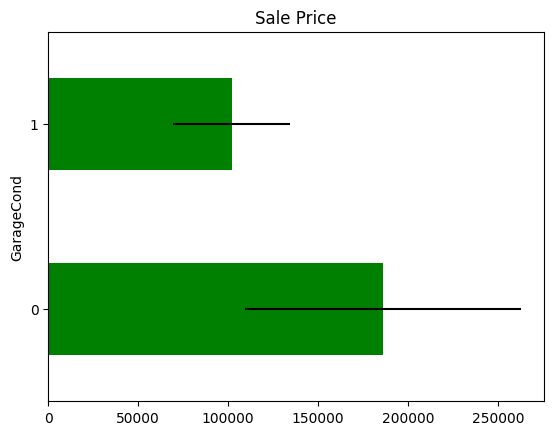

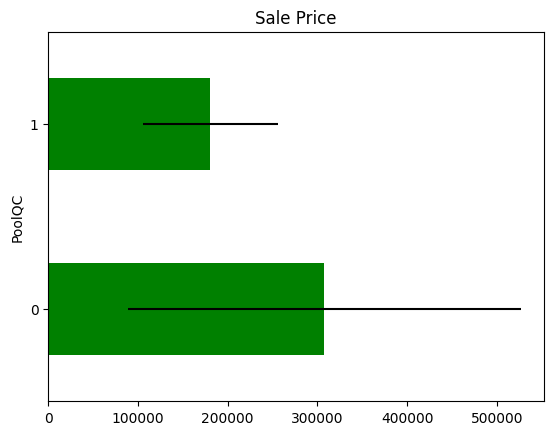

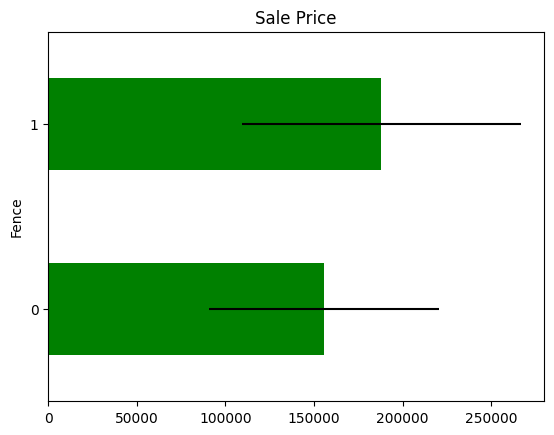

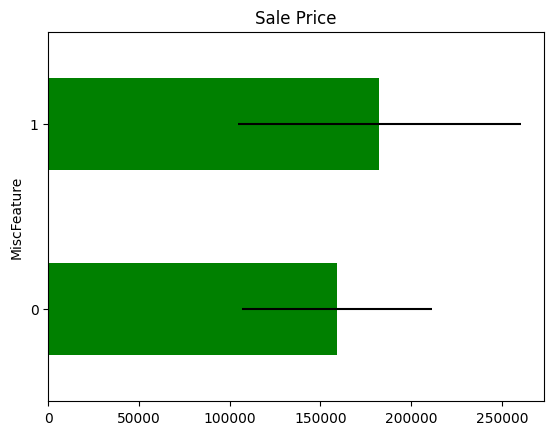

In [12]:
for culumn in missing_columns.index:
    missing_value_influance_on_target(train_data, culumn)

What have i just created?
1. Firslty, we devide data (columns) on those who has missing values = 1 and does not have missing values =1 
2. Then we group by data by new column 1 nad 0 and calcualte mean SalePraice and standard deviation
3. Then we plot results 

* How to interpret results? 
    - The leanght of the bar represents the mean SalePrice for each grup (1 with missing vlaues and 0 without missing values)
    - Black line is standard deviation = how much values of SalePrice differ from the mean
    - Let's analyzie one example to make sure we are on the same page. For example `PoolQC`. We know that this feature has 99% of missing data. This plot tells us that where informaion is missing the mean SalePrice of house is higher and also the the mean differ much more than where we have information. That concludes that `PoolQC` values are not missing at random, because there is relationship between `SalePrice` and information in `PoolQC`. 
    
This approach allows us to understand if it is a good idea to delate feature from dataset. Let's think about `PoolQC` again. When we would just chcek how many missing values does that feature has we would be schoked to see 99%! And it may sound reasonable to just drop that feature. **BUT** thanks to our above plots we know that this feature is corelated with target `SalePrice` - and if we think about it for a second that makes sanese that houses with pools shoud be sold for higher prices (not all features might be so easy to understnd in real wordl like that example). Thats why we wont drop that feature but impute it and create a new binary feature that indicates where data was missing.


what do to do next? I will follow that approach:
1. First of all we have to keep in mind what "missing" data are. In this case based od data description it means "No feature" so in Pool Quality feature that means there is no pool. We need to explore data description to understend taht. 
2. If feature has more than 50% of missing values and its seems to carry some information (based on above plots), and also NA does not mean anything based on data description i will input the information and create a feature "is_missing..." to show the model that missing inforamtion has a value. If the feature is not "correlated" i will drop it. 
3. If feature has 5%-50% missing data,and its seems to carry some information (based on above plots), i will input the information and create a feature "is_missing..." to show the model that missing inforamtion has a value. If there’s no association with the target, impute and skip the missing indicator.
4. If feature has less than 5% of missing data i will just impute it.


This apporach was presented to my by: https://colab.research.google.com/drive/1dM0cyxR6bsaXCYJh8DUTSwkXIHhuQnhj?usp=sharing#scrollTo=rPbjhVFw0dtZ

## Deep dive into the dataset
To prevent that notebook from beeing to long and "boring" i will do that on my own and present findings below

<Axes: >

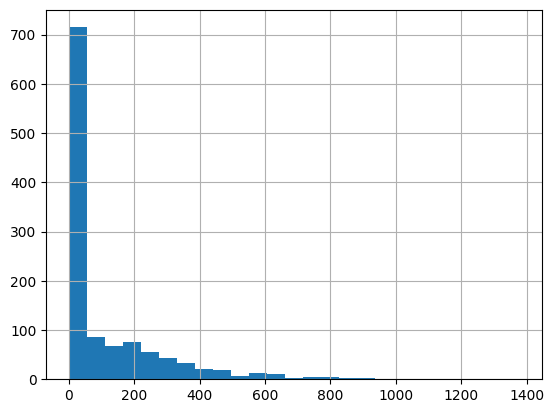

In [13]:
train_data["MasVnrArea"].hist(bins=25)

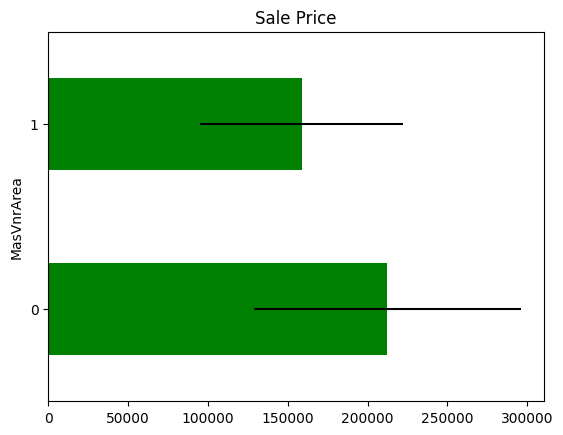

In [14]:
zero_value_influance_on_target(train_data,"MasVnrArea")

In [15]:
sum(train_data["MasVnrArea"]==0)*100/len(train_data["MasVnrArea"])

57.705479452054796

57% of data in MasVnrArea: Masonry veneer area in square feet are zeros. That will lead to very right skewed dataset

<Axes: >

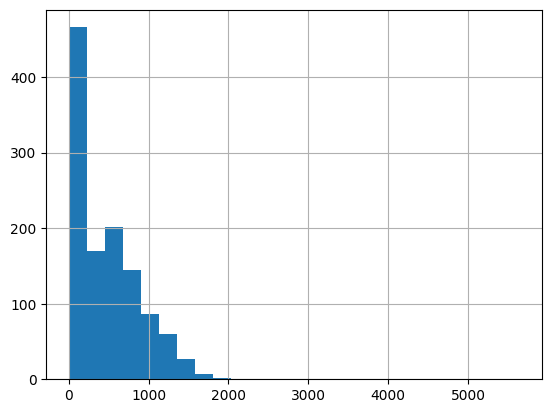

In [16]:
train_data["BsmtFinSF1"].hist(bins=25)

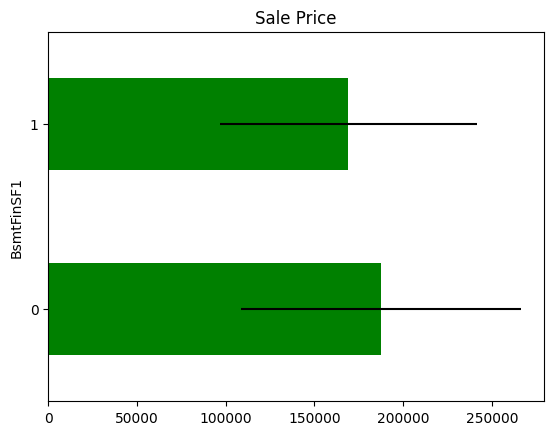

In [17]:
zero_value_influance_on_target(train_data,"BsmtFinSF1")

In [18]:
sum(train_data["BsmtFinSF1"]==0)*100/len(train_data["BsmtFinSF1"])

31.934931506849313

Almost 32 % of data has 0 value of square feet.

<Axes: >

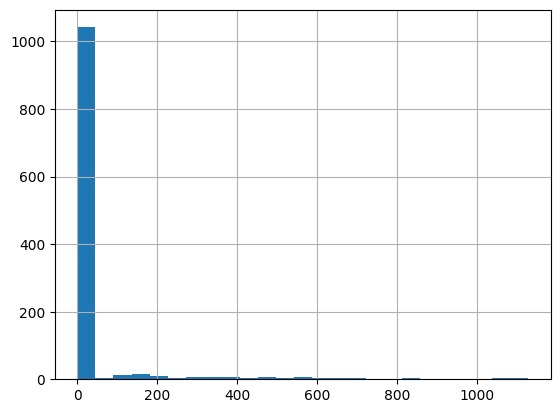

In [19]:
train_data["BsmtFinSF2"].hist(bins=25)

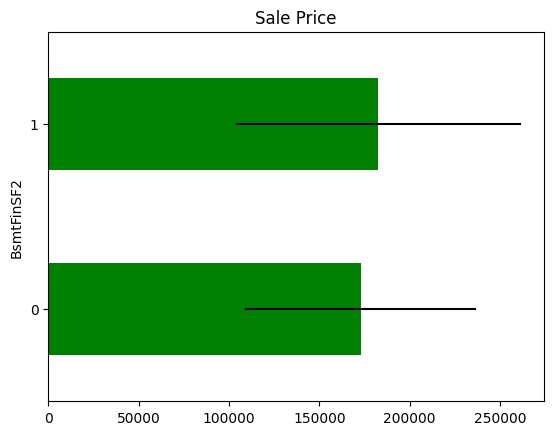

In [20]:
zero_value_influance_on_target(train_data,"BsmtFinSF2")

In [21]:
sum(train_data["BsmtFinSF2"]==0)*100/len(train_data["BsmtFinSF2"])

88.78424657534246

88% of hoems does not have typo2 finsihed baseemnt aera

<Axes: >

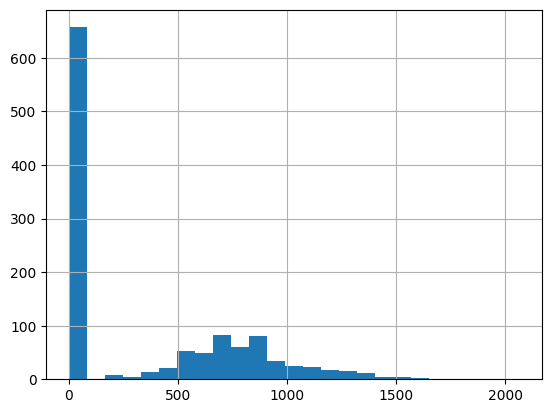

In [22]:
train_data["2ndFlrSF"].hist(bins=25)

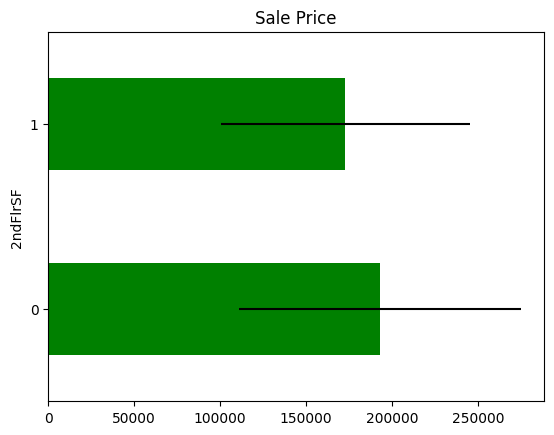

In [23]:
zero_value_influance_on_target(train_data,"2ndFlrSF")

In [24]:
sum(train_data["2ndFlrSF"]==0)*100/len(train_data["2ndFlrSF"])

56.25

56% of homes has zero in second floor square feet - to my understanding thats because that houses dos not have second floor

<Axes: >

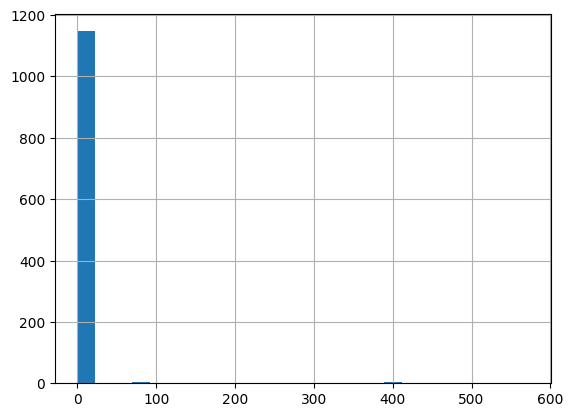

In [25]:
train_data["LowQualFinSF"].hist(bins=25)

In [26]:
sum(train_data["LowQualFinSF"]==0)*100/len(train_data["LowQualFinSF"])

98.20205479452055

98% of data in Low quality finished square feet (all floors) has 0 values. That means the houses are high qulity whitch is good. But data are extremly skewed and there are outlires


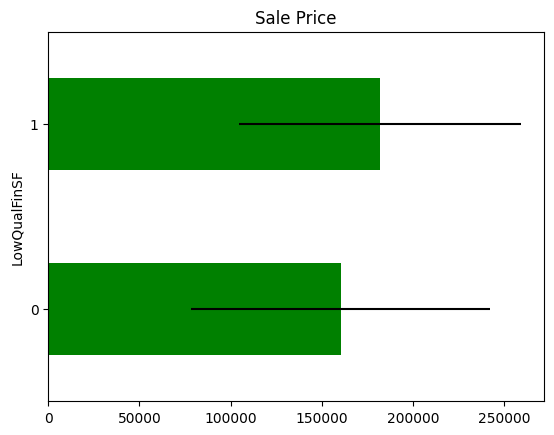

In [27]:
zero_value_influance_on_target(train_data,"LowQualFinSF")

As we can see, 1 = 0 squere feet finoshed with low quality tends to have higher Sale Price whitch is what we can expect. Feature shound not be delated

<Axes: >

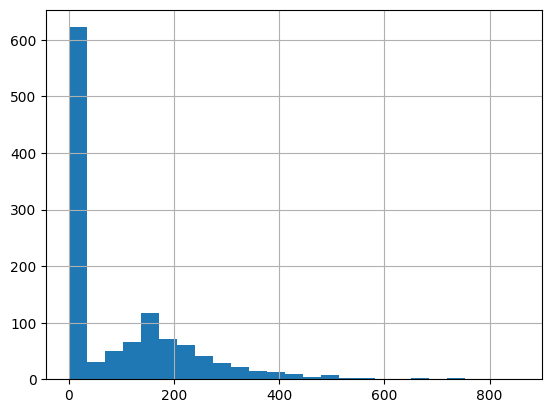

In [28]:
train_data["WoodDeckSF"].hist(bins=25)

In [29]:
sum(train_data["WoodDeckSF"]==0)*100/len(train_data["WoodDeckSF"])

52.91095890410959

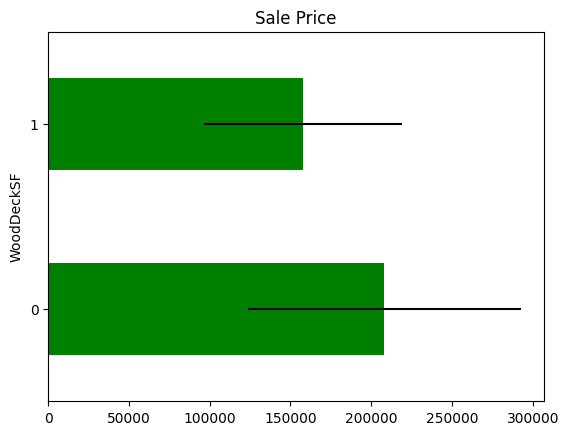

In [30]:
zero_value_influance_on_target(train_data,"WoodDeckSF")

As can be expectet houses with Wood Deck have significatly higher Sale Price. 53% of hauses have 0 square feet are whitch means they do not have wooden deck

<Axes: >

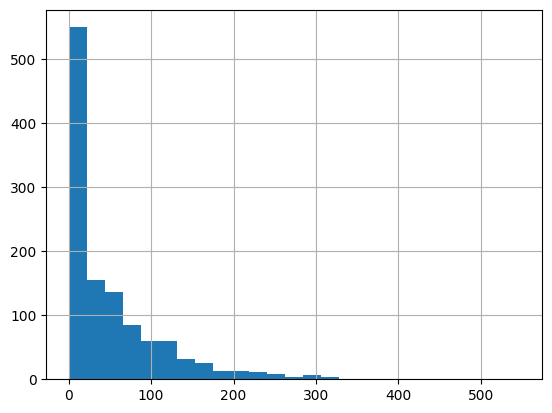

In [31]:
train_data["OpenPorchSF"].hist(bins=25)

In [32]:
sum(train_data["OpenPorchSF"]==0)*100/len(train_data["OpenPorchSF"])

43.83561643835616

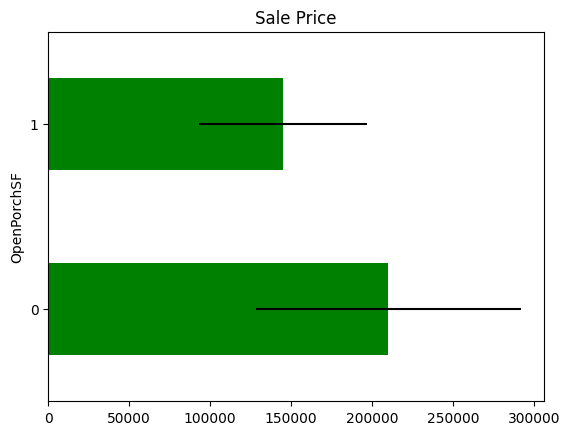

In [33]:
zero_value_influance_on_target(train_data,"OpenPorchSF")

43% of data has 0 value in that feature, whitch means they do not have open porch, but that feature has impact on sale price

<Axes: >

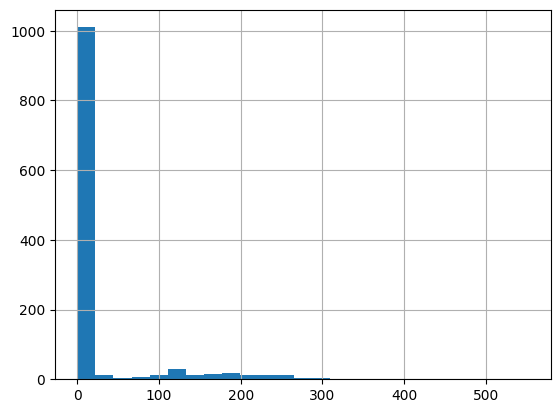

In [34]:
train_data["EnclosedPorch"].hist(bins=25)

In [35]:
sum(train_data["EnclosedPorch"]==0)*100/len(train_data["EnclosedPorch"])

86.3013698630137

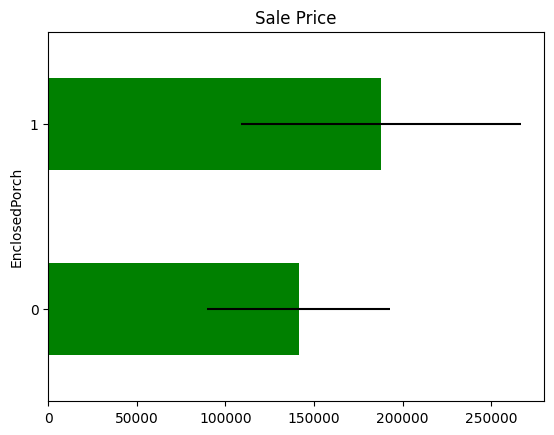

In [36]:
zero_value_influance_on_target(train_data,"EnclosedPorch")

86% od homes does not have enclosed porch, but what is more interesting , houses that do not posses that amenities tends to have higher mean sale price

<Axes: >

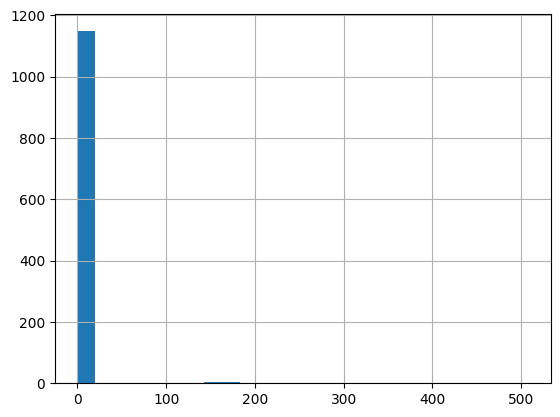

In [37]:
train_data["3SsnPorch"].hist(bins=25)

In [38]:
sum(train_data["3SsnPorch"]==0)*100/len(train_data["3SsnPorch"])

98.28767123287672

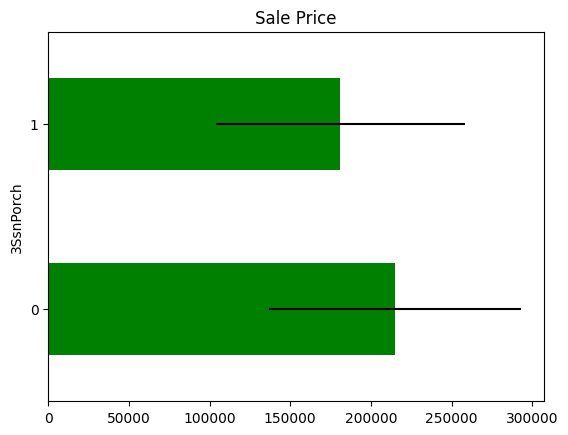

In [39]:
zero_value_influance_on_target(train_data,"3SsnPorch")

98% of homes does not have 3 season porch, bit those who have it tend to have higher sale price

<Axes: >

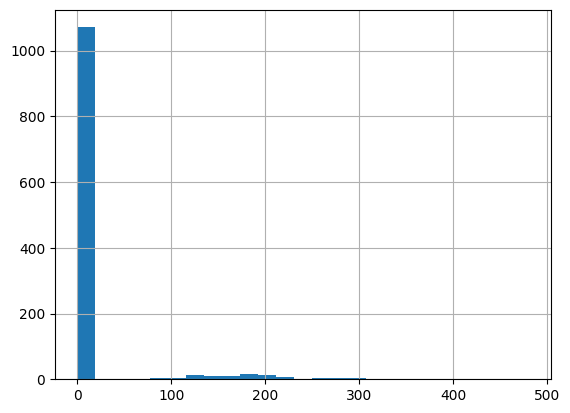

In [40]:
train_data["ScreenPorch"].hist(bins=25)

In [41]:
sum(train_data["ScreenPorch"]==0)*100/len(train_data["ScreenPorch"])

91.69520547945206

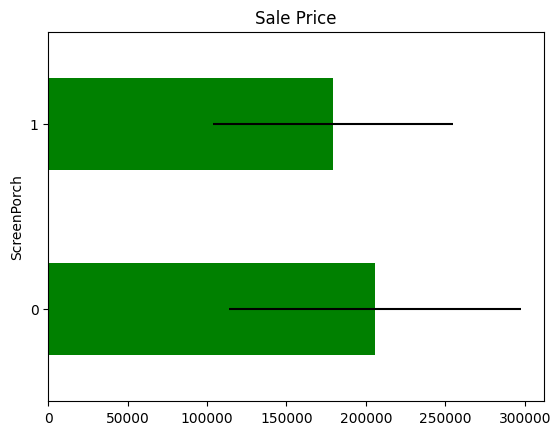

In [42]:
zero_value_influance_on_target(train_data,"ScreenPorch")

92% of homes does not have Screen porch area but data suggests that houses that have it tend to have higher prices 

<Axes: >

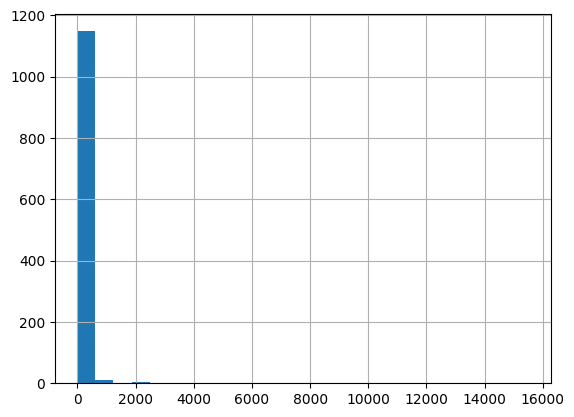

In [43]:
train_data["MiscVal"].hist(bins=25)

In [44]:
sum(train_data["MiscVal"]==0)*100/len(train_data["MiscVal"])

96.23287671232876

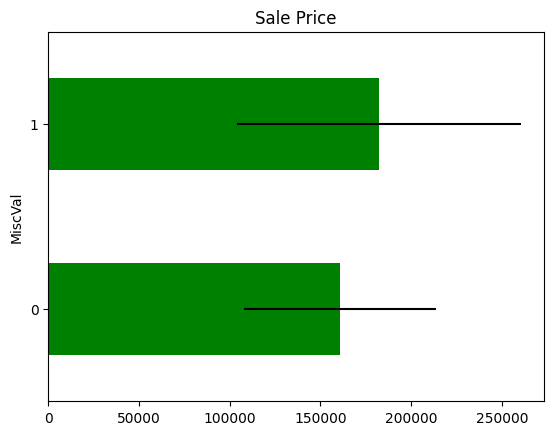

In [45]:
zero_value_influance_on_target(train_data,"MiscVal")

96% of data set has values of zero, that means most of the houses does not have "miscellaneous feature". What is a bit contrary to intuition which homes have higher sale price.

In [46]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(train_data.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1957,1957,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,Gd,CBlock,TA,TA,No,Rec,922,Unf,0,392,1314,GasA,TA,Y,SBrkr,1314,0,0,1314,1,0,1,0,3,1,TA,5,Typ,0,NaN,Attchd,1957.0,RFn,1,294,TA,TA,Y,250,0,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,7,1993,1994,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,799,799,GasA,Gd,Y,SBrkr,799,772,0,1571,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,RFn,2,380,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Feedr,Norm,1Fam,1Story,5,7,1910,1950,Gable,CompShg,MetalSd,Wd Sdng,NaN,0.0,TA,TA,CBlock,Fa,TA,No,Unf,0,Unf,0,796,796,GasA,Gd,Y,FuseA,796,0,0,796,0,0,1,0,2,1,TA,4,Typ,0,NaN,NaN,NaN,NaN,0,0,NaN,NaN,P,328,0,164,0,0,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Feedr,Norm,1Fam,1.5Fin,5,7,1937,1950,Gable,CompShg,Wd Sdng,Wd Sdng,BrkFace,252.0,TA,TA,BrkTil,Gd,TA,No,ALQ,569,Unf,0,162,731,GasA,Ex,Y,SBrkr,981,787,0,1768,1,0,1,1,3,1,Gd,7,Typ,2,TA,Detchd,1939.0,Unf,1,240,TA,TA,Y,0,0,264,0,0,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,SWISU,Norm,Norm,1Fam,1.5Fin,5,6,1924,1950,Gable,CompShg,BrkFace,Wd Sdng,NaN,0.0,TA,TA,BrkTil,TA,TA,No,LwQ,218,Unf,0,808,1026,GasA,TA,Y,SBrkr,1026,665,0,1691,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Detchd,1924.0,Unf,1,308,TA,TA,Y,0,0,242,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000


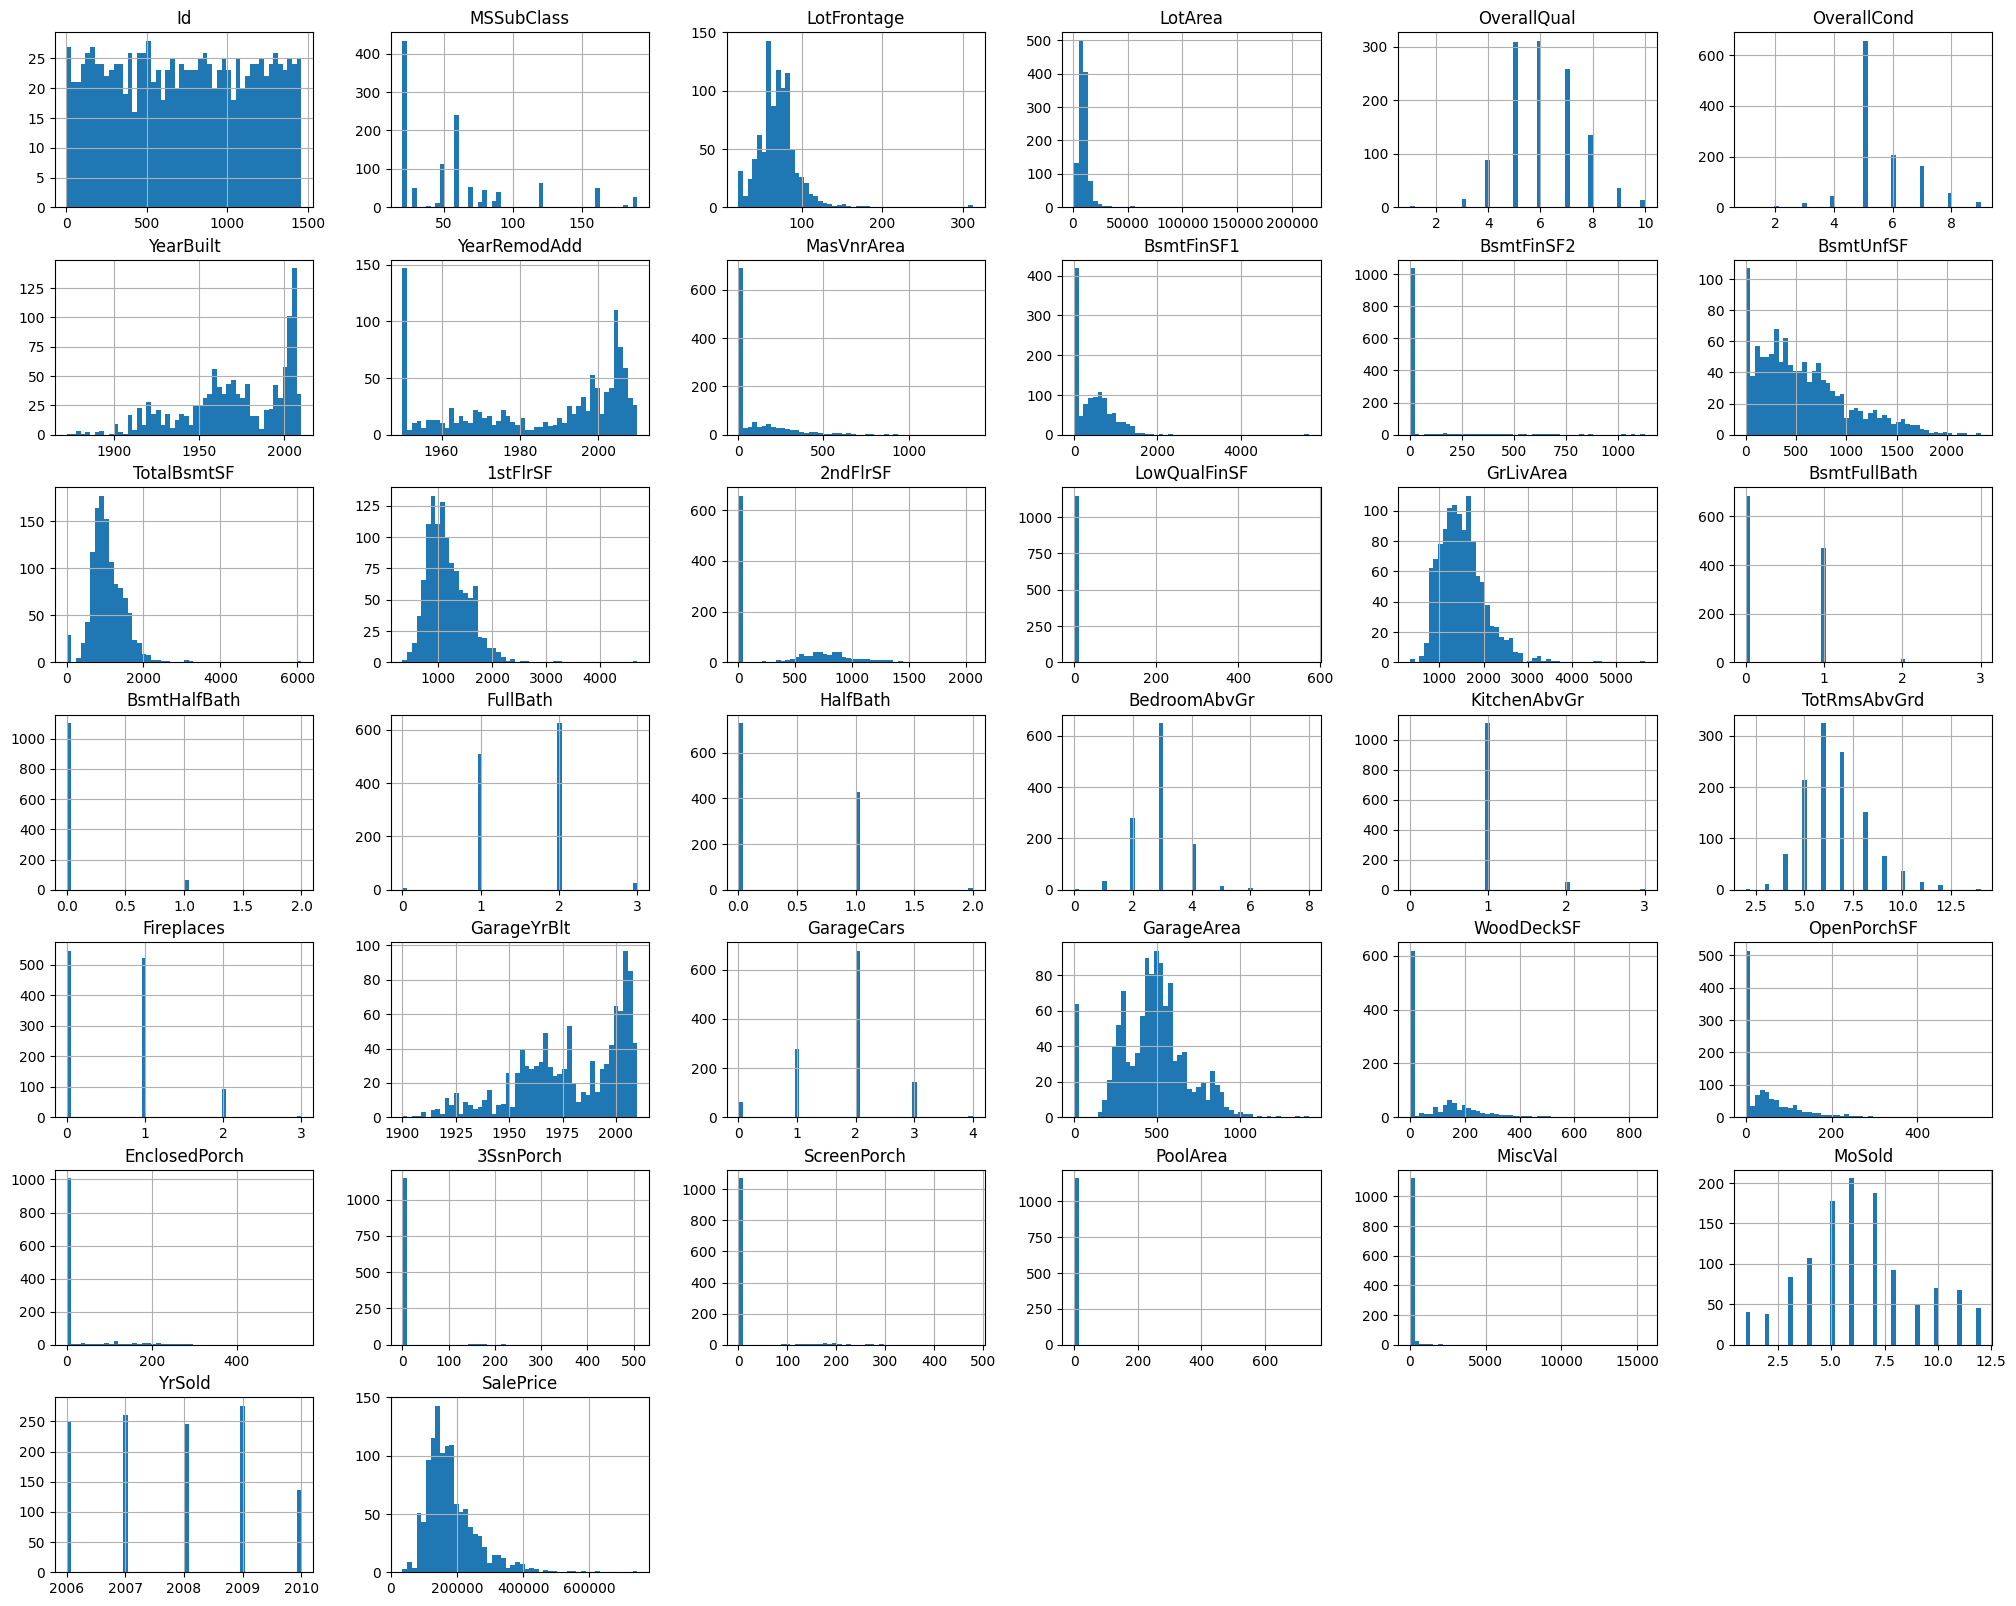

In [47]:
train_data.hist(figsize=(25,20), bins=50)
plt.show()

Based on the above plots, we can fairly say that not all of them exhibit a Gaussian-like distribution. We can transform some features to make them more Gaussian-like.
However, keep in mind that we should only apply such transformations to numerical variables that are not categorical or ordinal features.
We need to identify which of them are categorical and which are continuous.

To summarize, we will now create a list of categorical and continuous features. In my opinion, and after carefully studying the data description, every feature with fewer than 25 unique values, except for `MiscVal`, `LowQualFinSF`, `PoolArea`, and `3SsnPorch`, should be considered categorical. For now, we will treat those features as categorical. Later, we will create additional features related to them and handle them as continuous features where appropriate.

In [48]:
def prepare_numercial_categorical_date_feature(dataframe):
    """ Funsction will return numerical, categorical, datetime features in format of list of strings
    dataframe - have to be witht ID column and with SalePrice"""
    unique = {}
    year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', "MoSold"]
    my_numerical = ["LowQualFinSF", "MiscVal", "PoolArea", "3SsnPorch"]
    features_list = []

    if "Id" in dataframe.columns:
        dataframe = dataframe.drop("Id", axis=1, errors="ignore") ### 
    else:
        pass
    
    for column, data in dataframe.items():
        number_of_unique_val = dataframe[column].nunique()
        unique[column] = number_of_unique_val

    features_list_sorted = sorted(unique.items(),key=lambda x:x[1], reverse=True)

    for feature,number in features_list_sorted:
        features_list.append(feature)
        
    categorical_features_list = features_list[19:]
    numercial_features_list = features_list[:19]



    # Categorical
    for feature in my_numerical:
        if feature in categorical_features_list:
            categorical_features_list.remove(feature)


    for feature in year_features:
        if feature in categorical_features_list:
            categorical_features_list.remove(feature)

    # Numerical
    for feature in my_numerical:
        if feature not in numercial_features_list:
            numercial_features_list.append(feature)

    for feature in year_features:
        if feature in numercial_features_list:
            numercial_features_list.remove(feature)



    return categorical_features_list, numercial_features_list,year_features




In [49]:
categorical_features_list, numercial_features_list,year_features = prepare_numercial_categorical_date_feature(train_data)

Now we will apply some transformations to the numerical data. Our goal is to make them look more Gaussian.
However, we will exclude features related to years, as later in this notebook, we will treat them as timestamps and apply some feature engineering techniques to extract useful information.

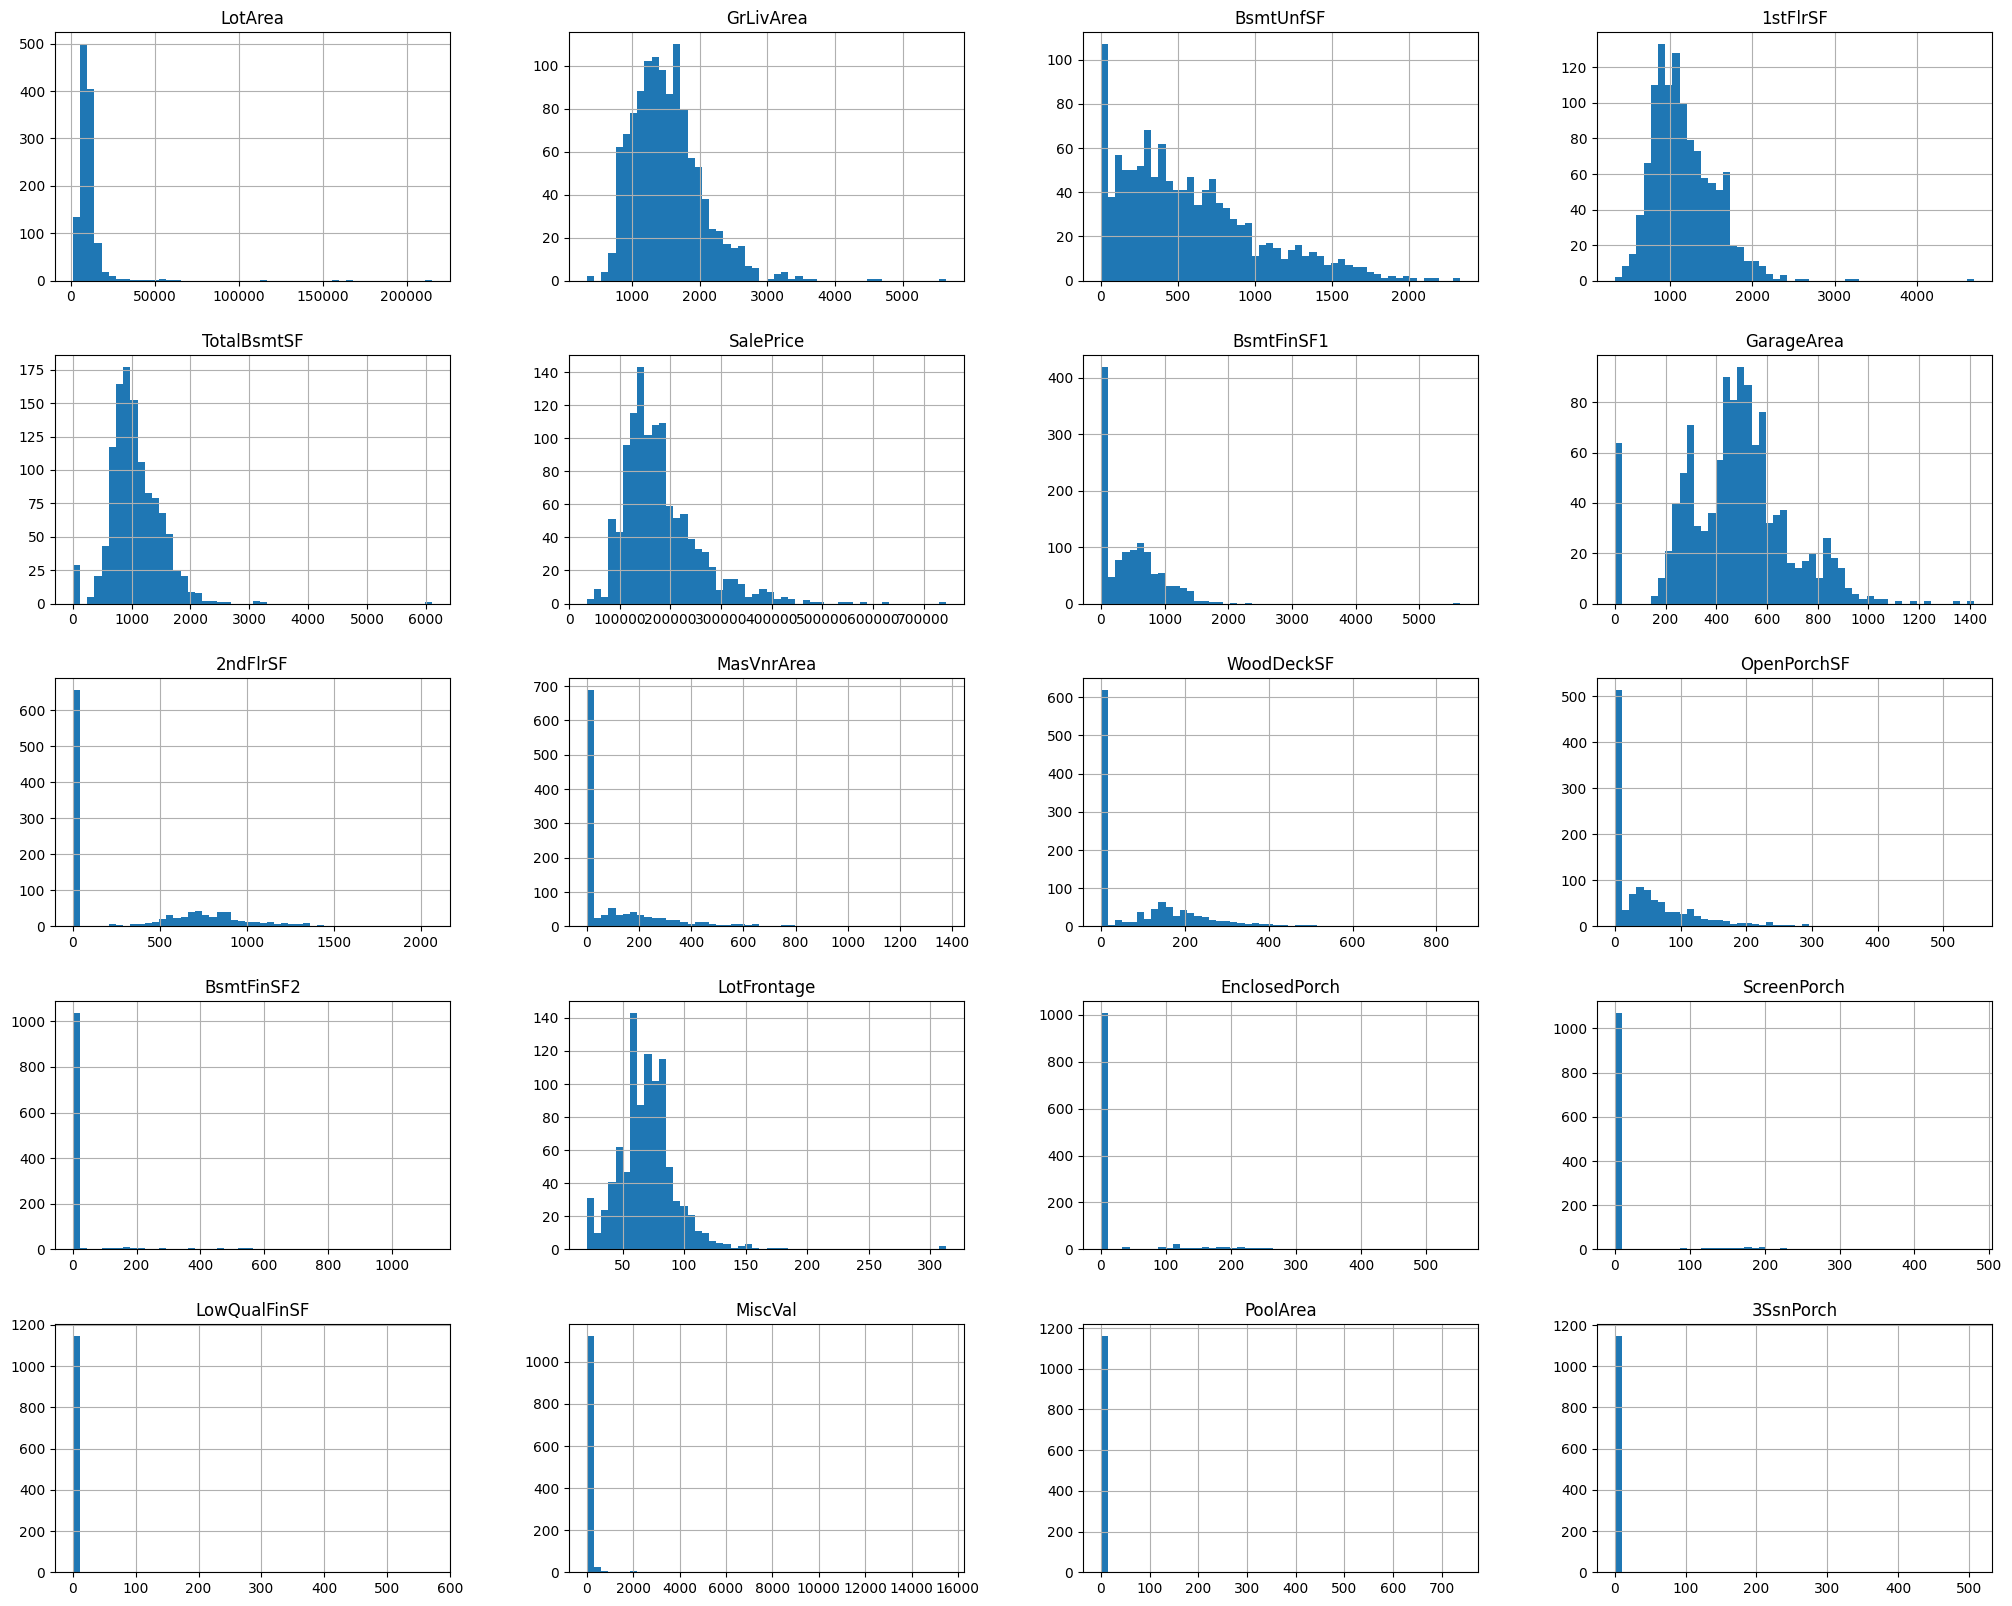

In [50]:
train_data[numercial_features_list].hist(figsize=(25,20), bins=50)
plt.show()

Just to test i will copy my dataset and transform data within the copy so if something will go wrong, i can easly go back

In [51]:
train_data_copy = train_data.copy() 
power_transfomer = PowerTransformer()

# Yeo-Jonson transformation
numerical_features_transformed = power_transfomer.fit_transform(train_data_copy[numercial_features_list])
train_data_copy[numercial_features_list] = numerical_features_transformed

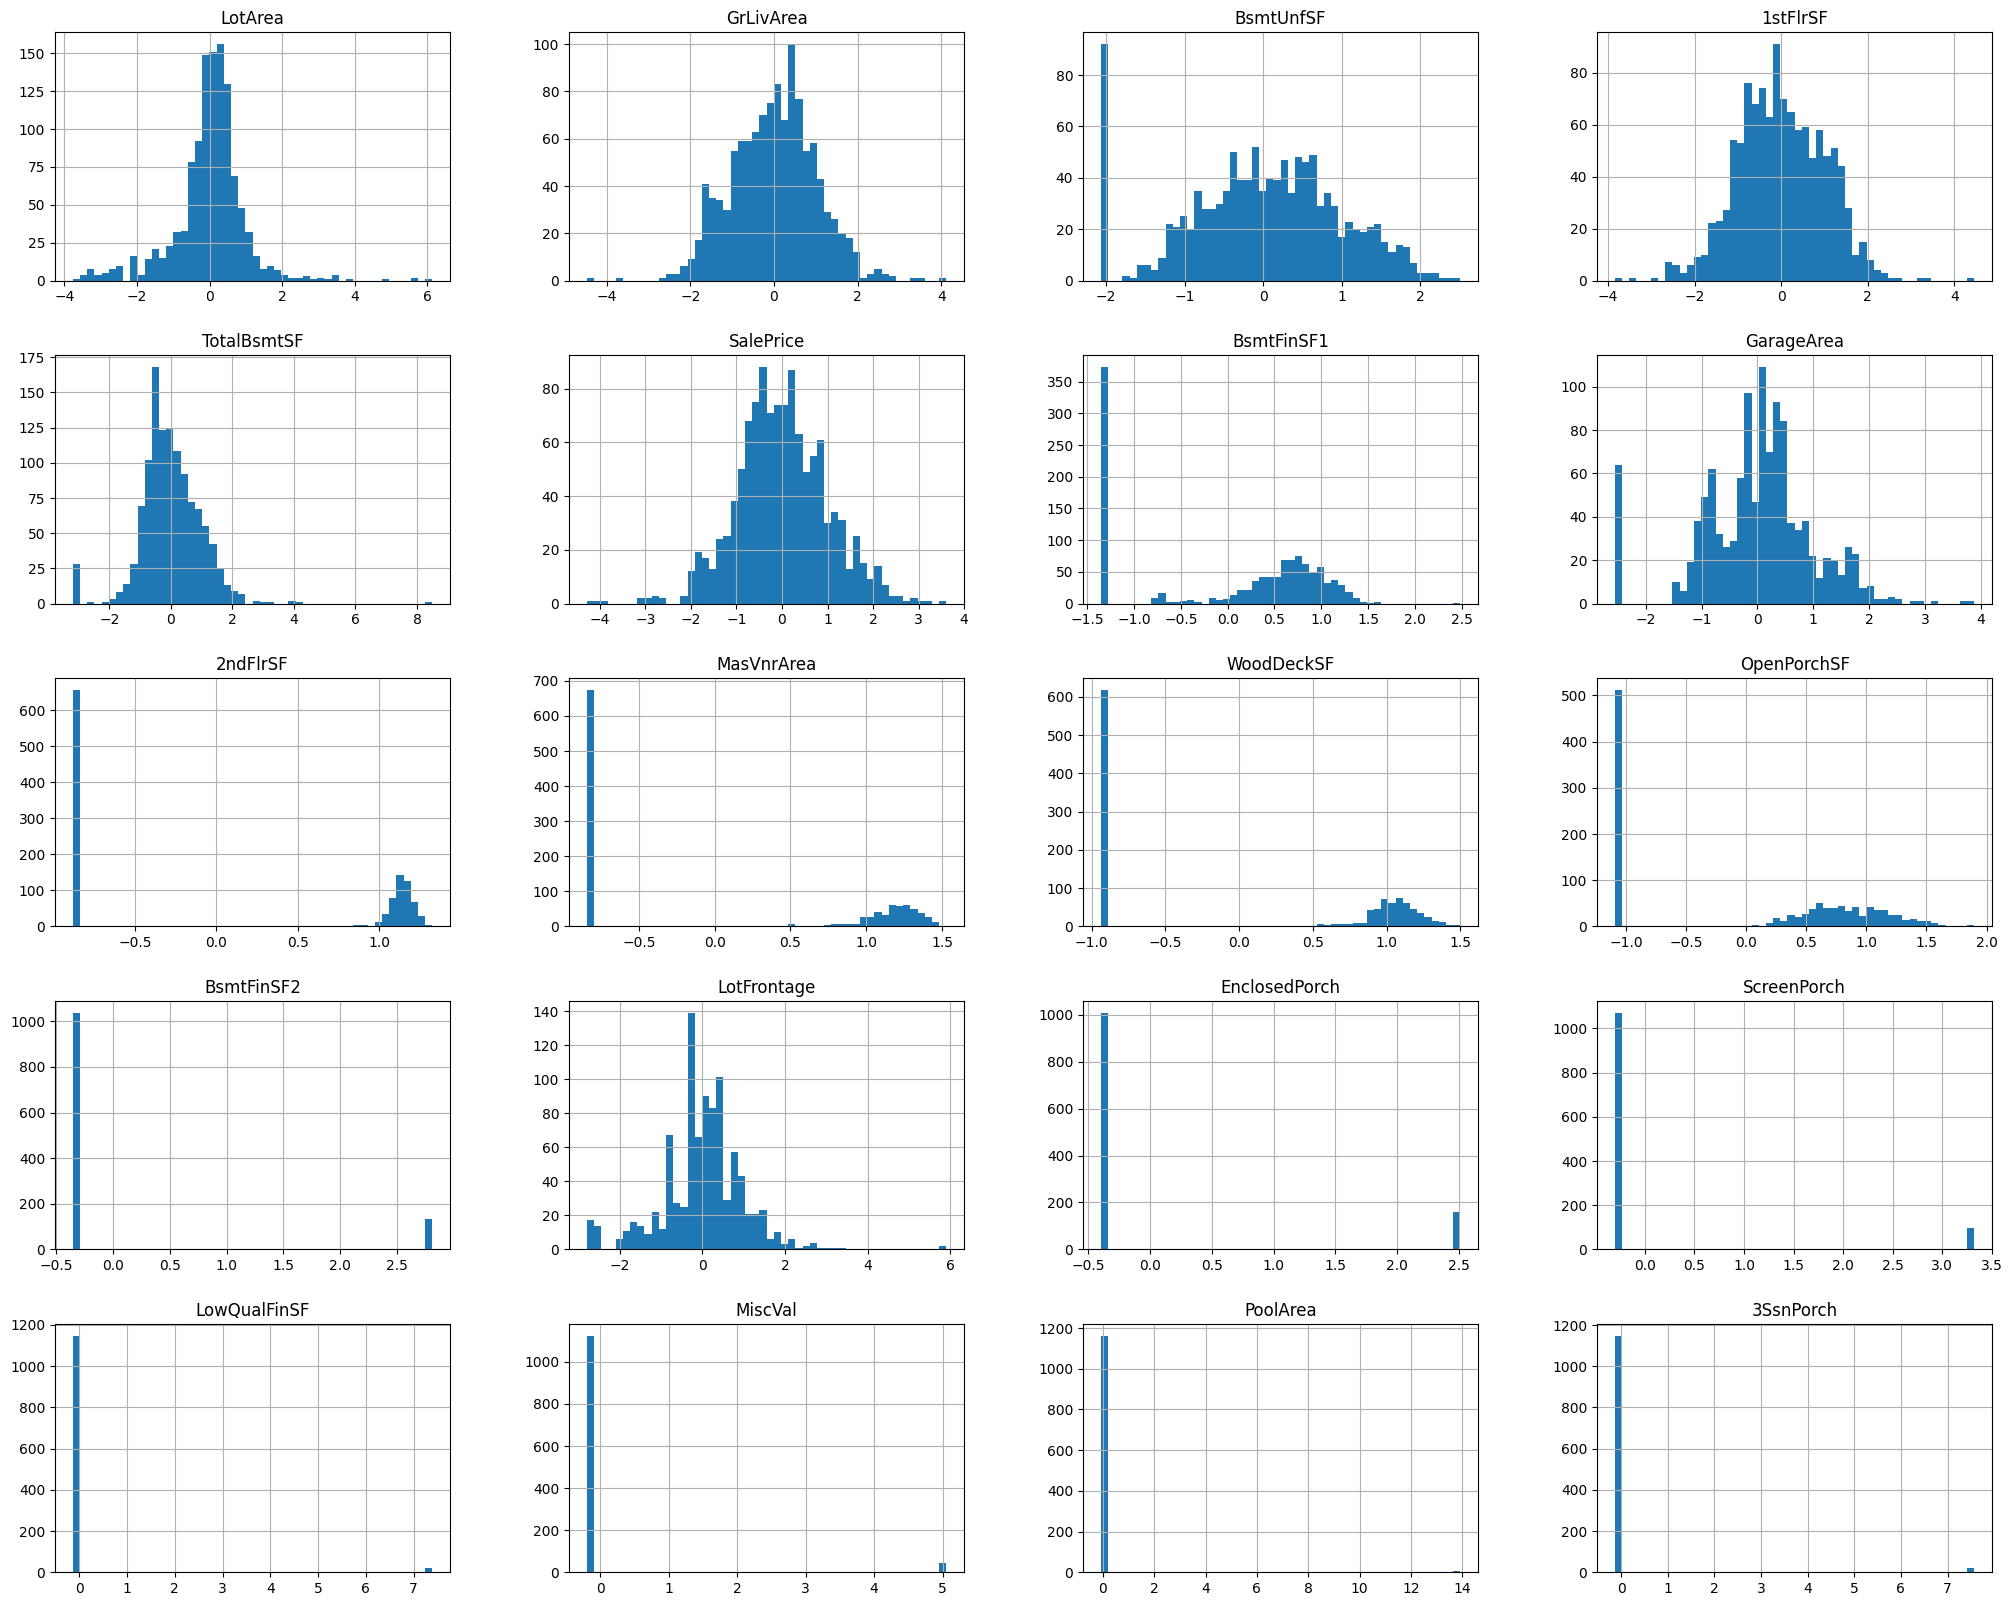

In [52]:
train_data_copy[numercial_features_list].hist(figsize=(25,20), bins=50)
plt.show()

Lets try different data transformation to check what fits best

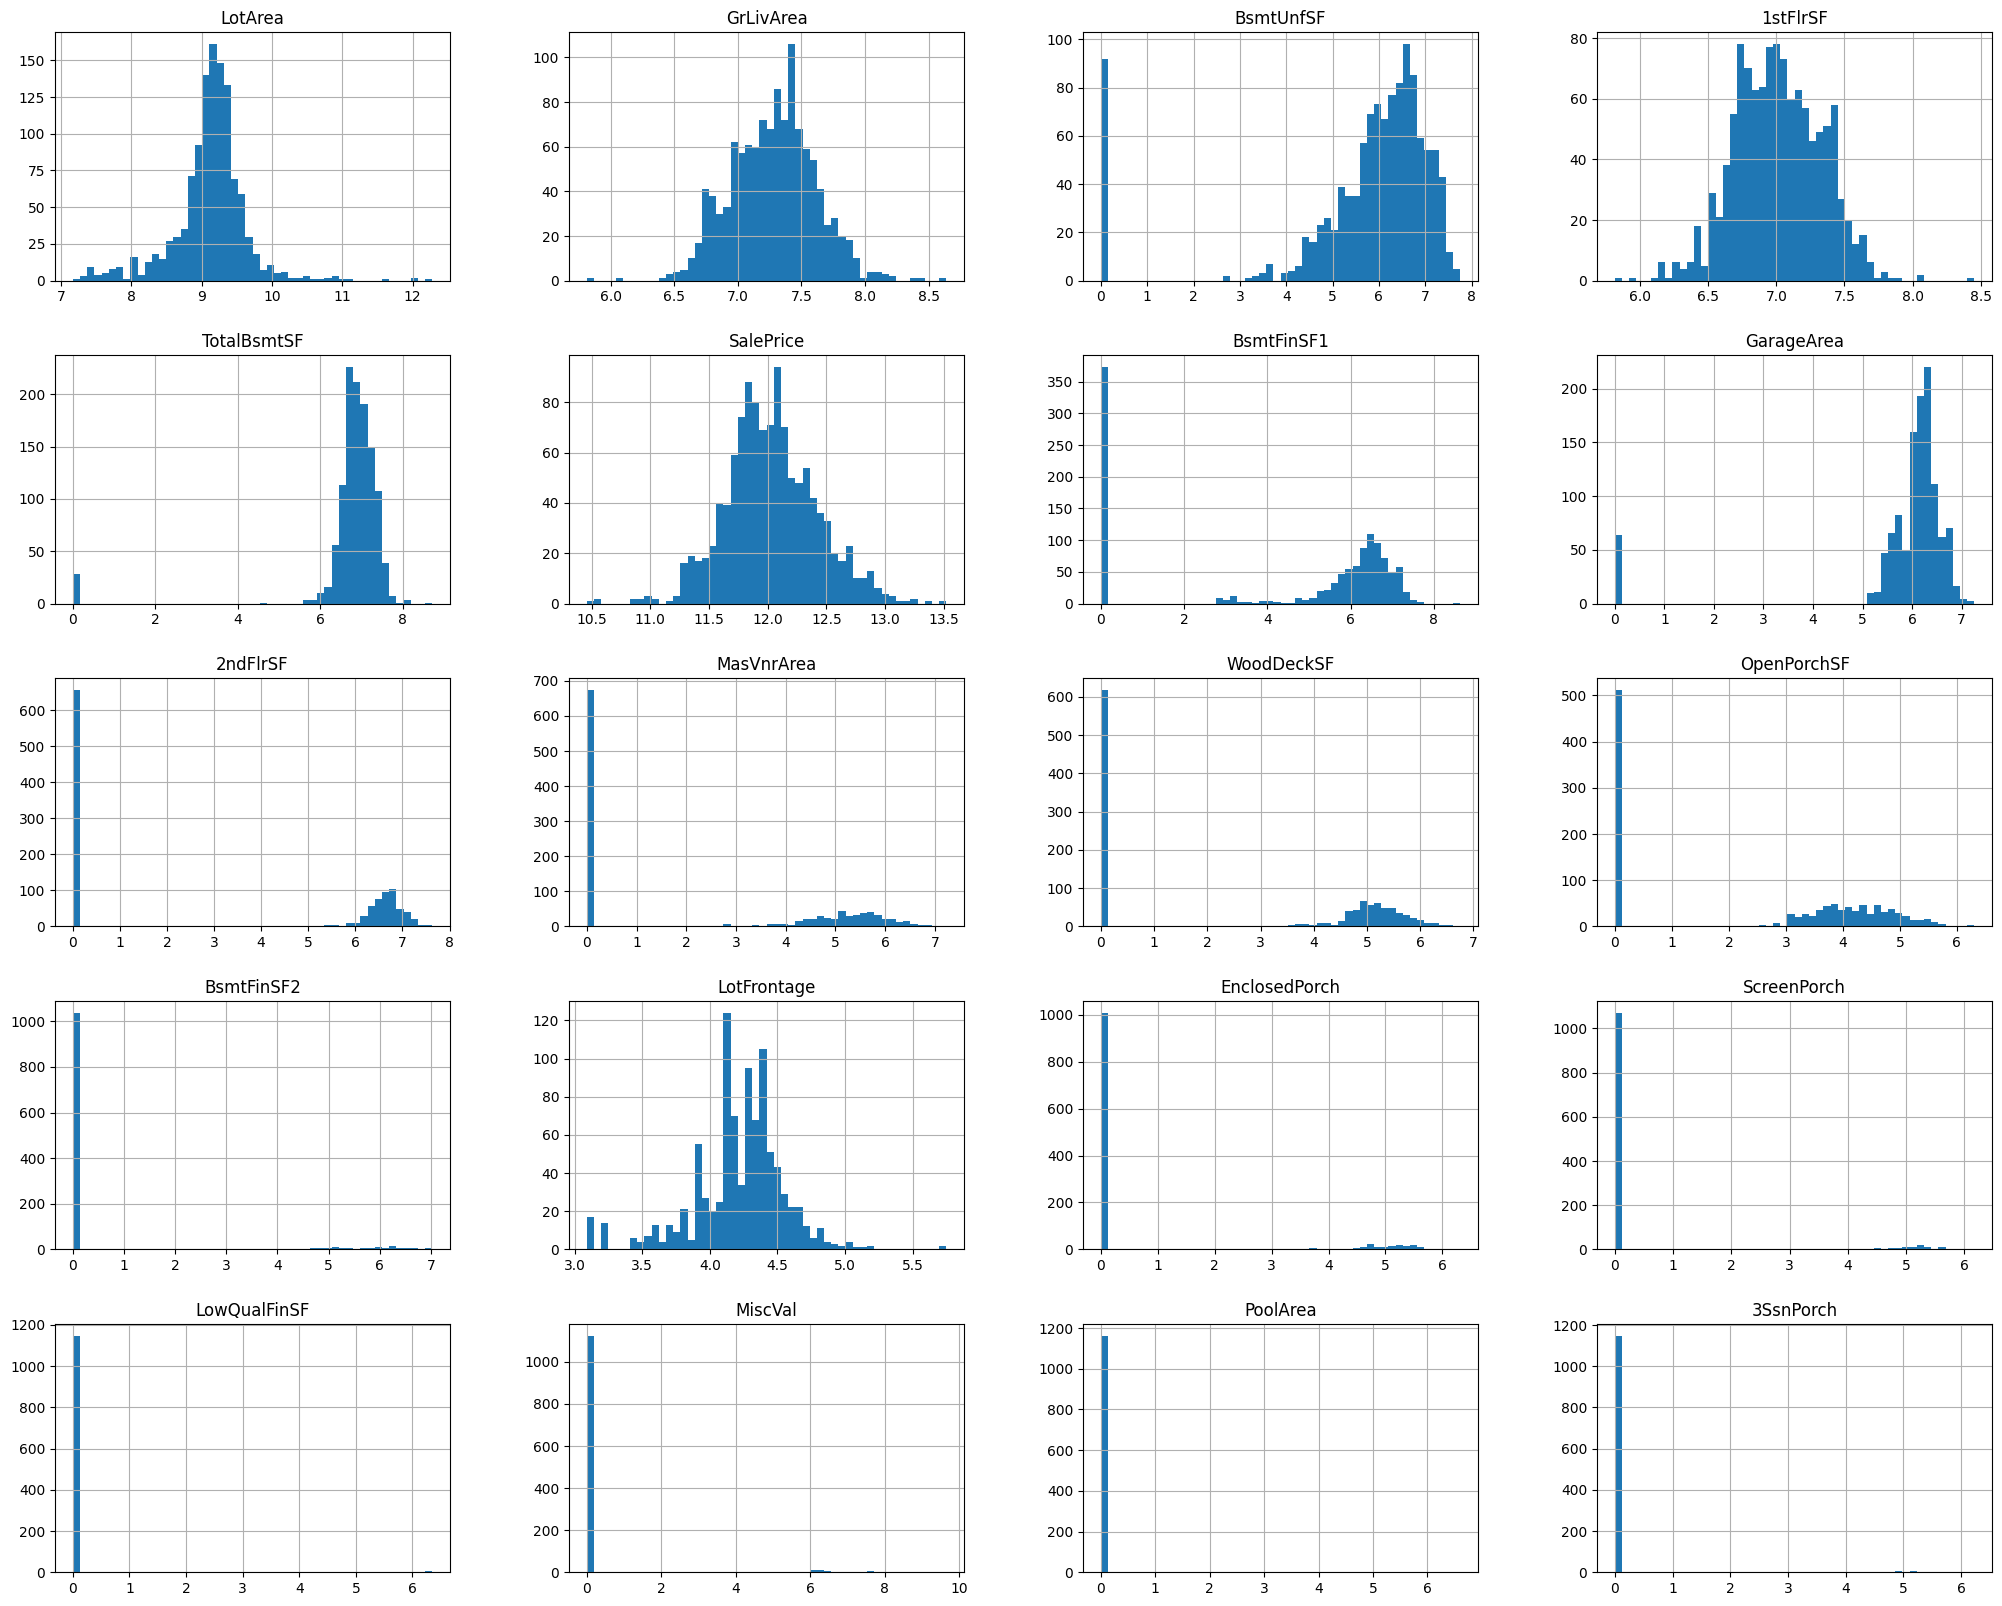

In [53]:
train_data_copy2 = train_data.copy() 
# Log transformation 
train_data_copy2[numercial_features_list] = np.log1p(train_data_copy2[numercial_features_list])
train_data_copy2[numercial_features_list].hist(figsize=(25,20), bins=50)
plt.show()

It is hard to determine which data transformation (log or Yeo-Johnson) to use. Both seem to give fairly good results, but in my opinion, Yeo-Johnson is more suited to this dataset. This is because we have many variables with values of 0, which would require the use of the log1p function, slightly modifying the data. Additionally, some transformations had little to no effect, such as in the feature `MasVnrArea`, where the data is extremely skewed.

### Time in dataset exploration

<Axes: >

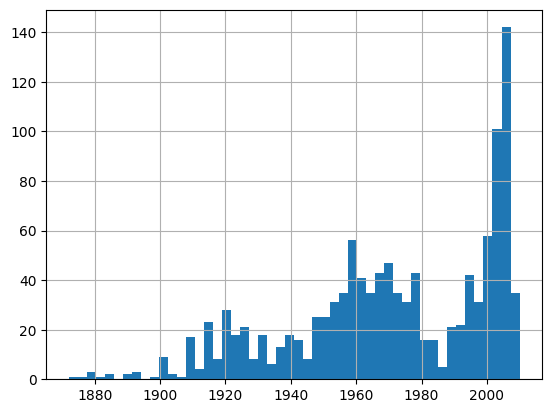

In [54]:
train_data["YearBuilt"].hist(bins=50)

Most of the houses were built around the year 2000.

In [55]:
year_grouped = train_data.groupby("YearBuilt") #DataFrameGroupBy Object - groups all data in unique values of years the house was build for example for every unique value (let’s say 1990), 
# it creates a group. This group contains all the rows in the DataFrame where "YearBuilt" equals 1990.
median_sale_price_in_year = year_grouped["SalePrice"].mean() # Calculate mean for each group

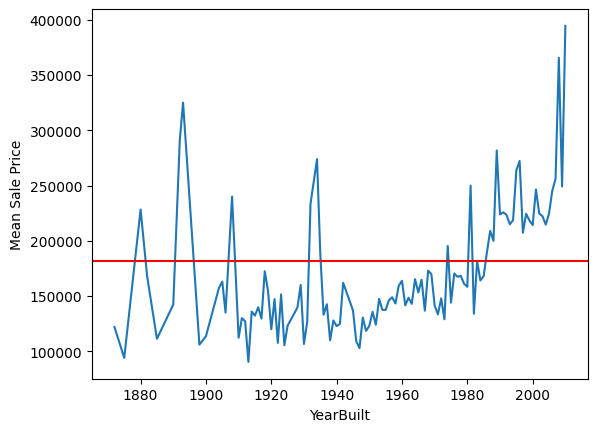

In [56]:
median_sale_price_in_year.plot()
plt.ylabel("Mean Sale Price")
plt.axhline(train_data["SalePrice"].mean(), color='r') 


Houses built in recent years (e.g., post-2000) have significantly higher mean sale prices compared to older houses.

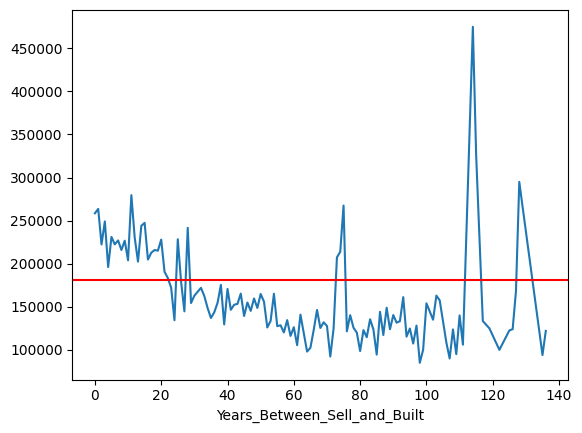

In [57]:

train_data_copy = train_data.copy() 
train_data_copy["Years_Between_Sell_and_Built"] = train_data_copy["YrSold"] - train_data_copy["YearBuilt"]

data_groupedby_Years_Between_Sell_and_Built = train_data_copy.groupby("Years_Between_Sell_and_Built")
mean_sale_price = data_groupedby_Years_Between_Sell_and_Built["SalePrice"].mean()
# data_groupedby_Years_Between_Sell_and_Built

mean_sale_price.plot()
plt.axhline(train_data["SalePrice"].mean(), color='r') 


Based oon that plot we can deduce that if the house is older its sale price will be higher. But keep in mind that houses build above 100 yeras old or even 50 yeras old are minority, there are only few examples so it is not a clever way to look at data. 

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


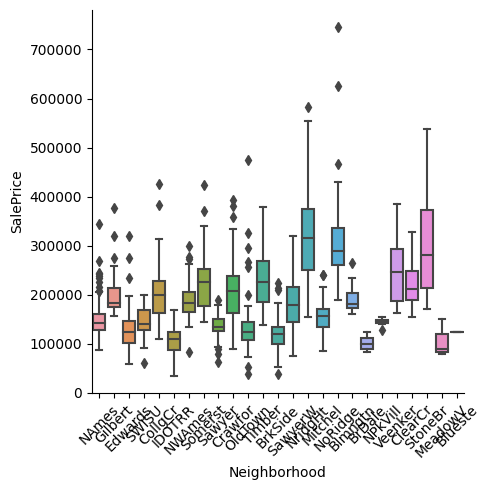

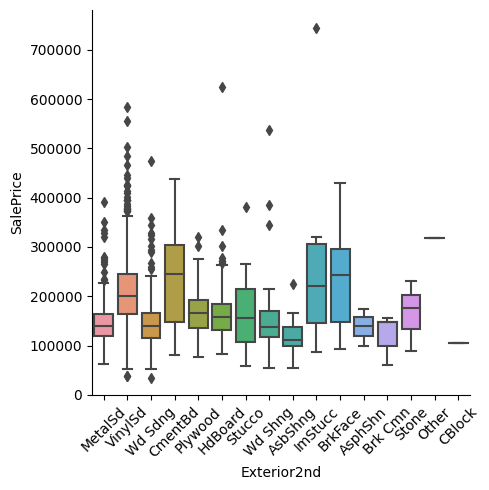

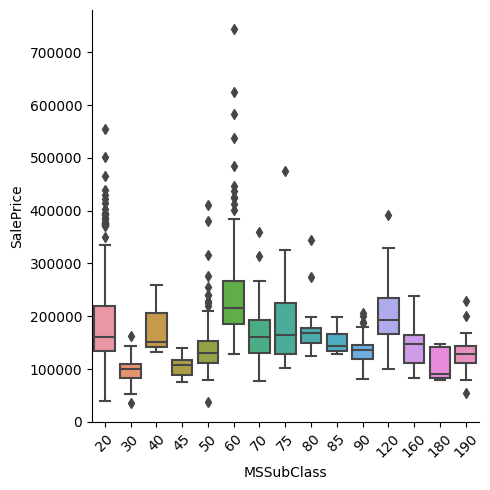

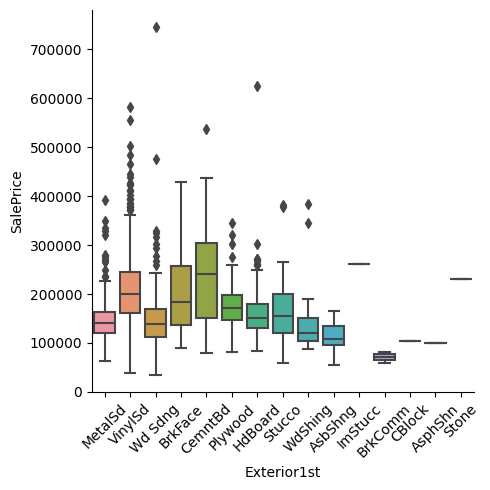

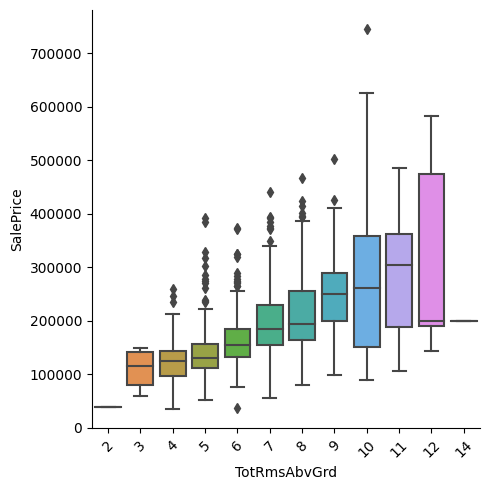

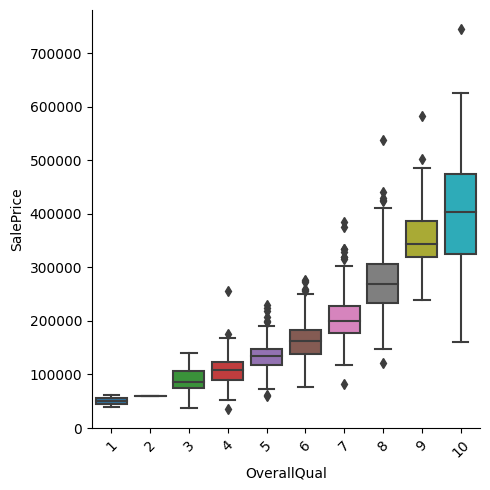

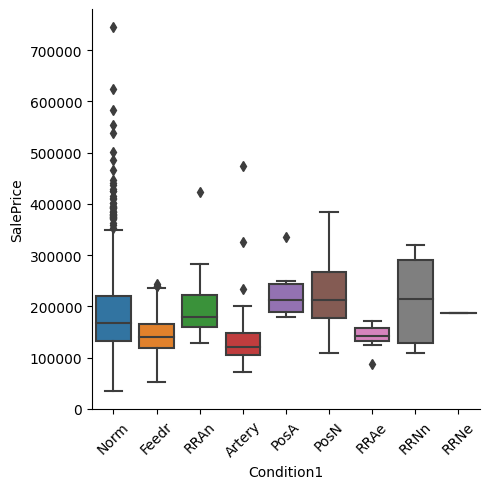

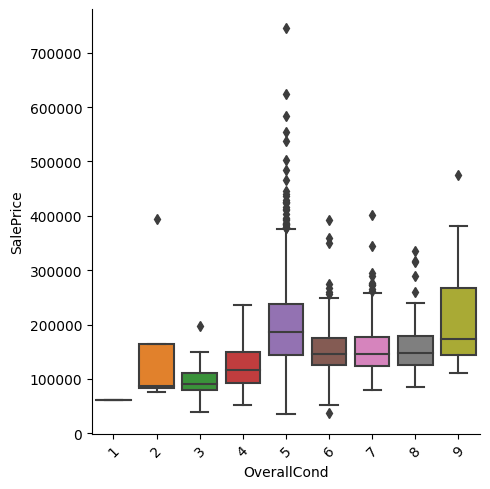

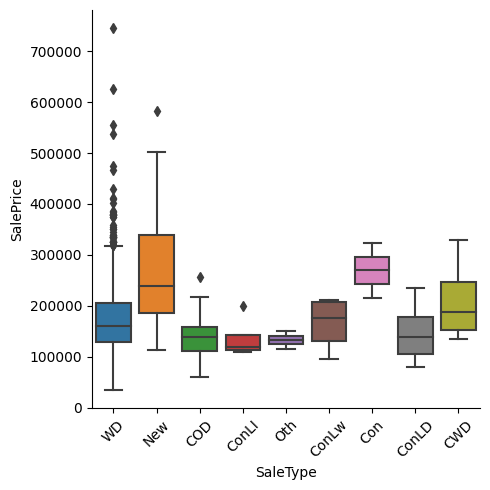

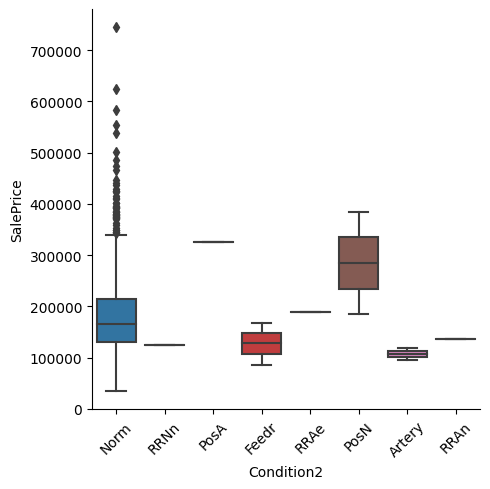

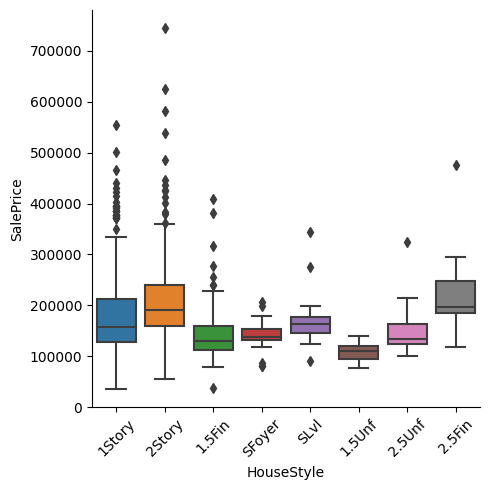

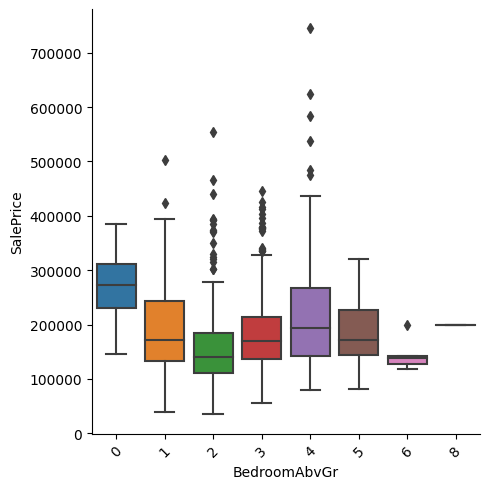

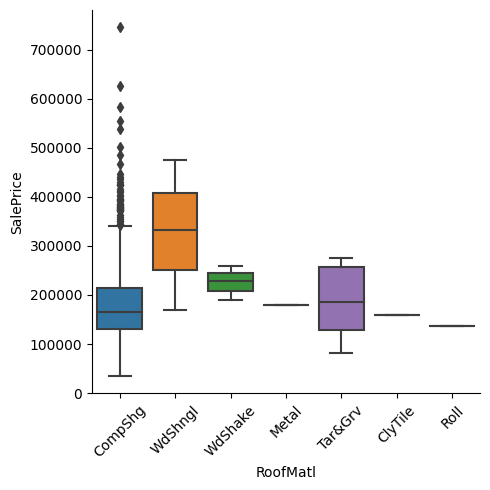

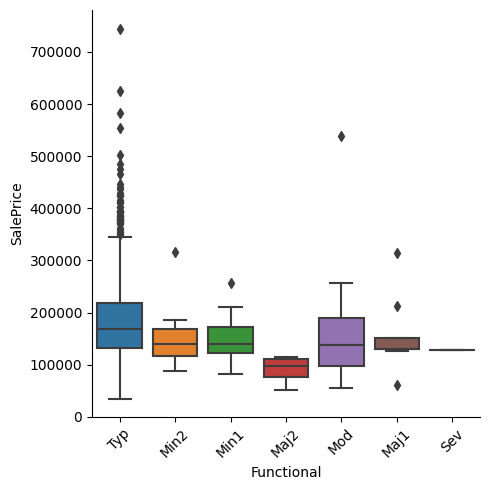

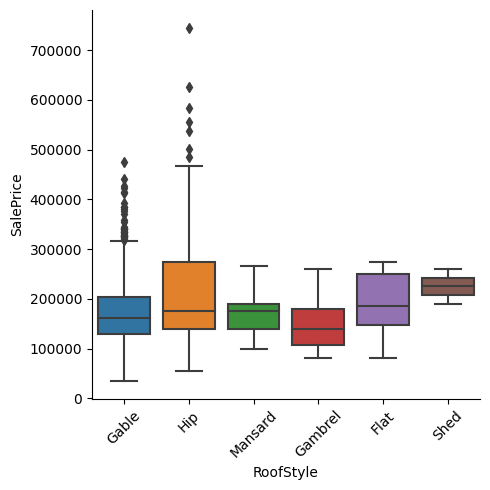

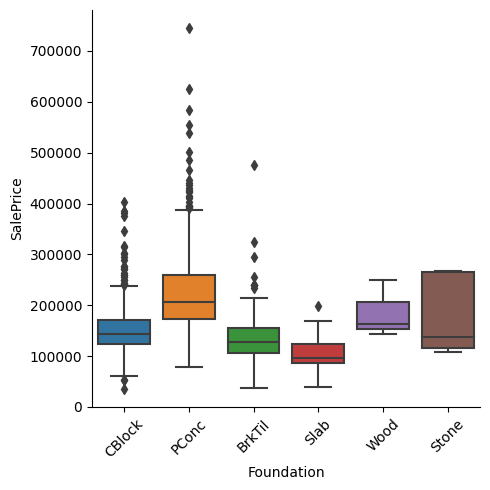

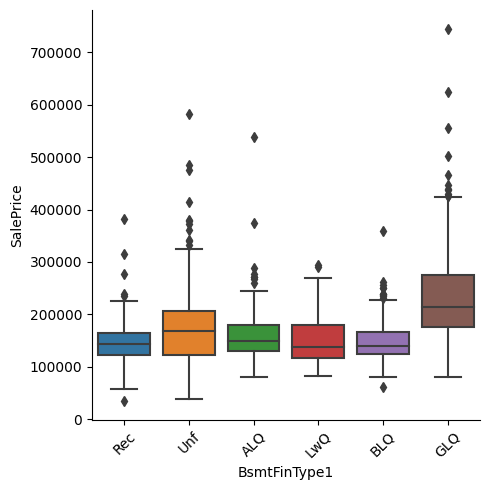

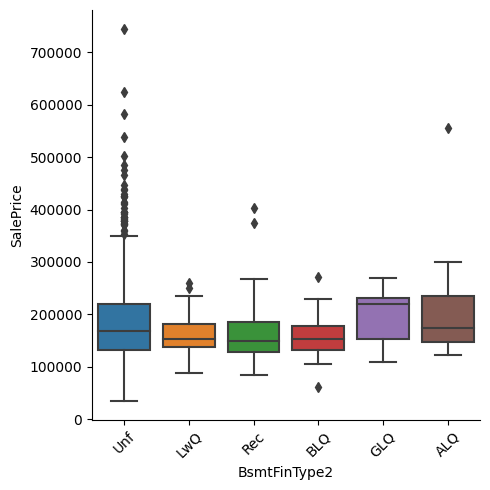

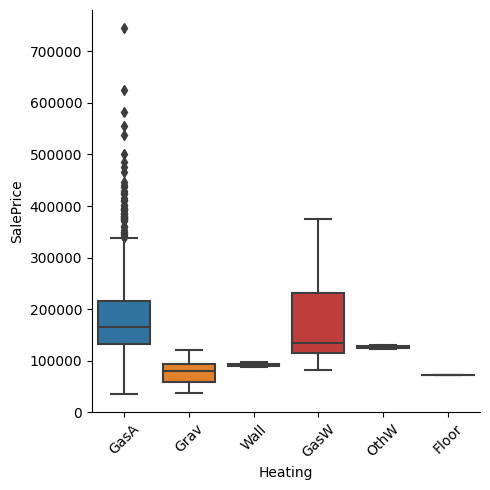

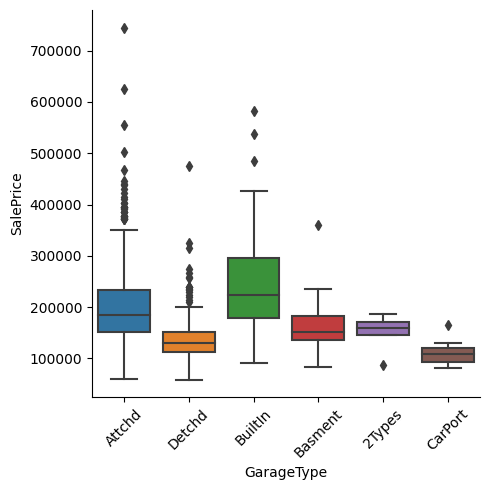

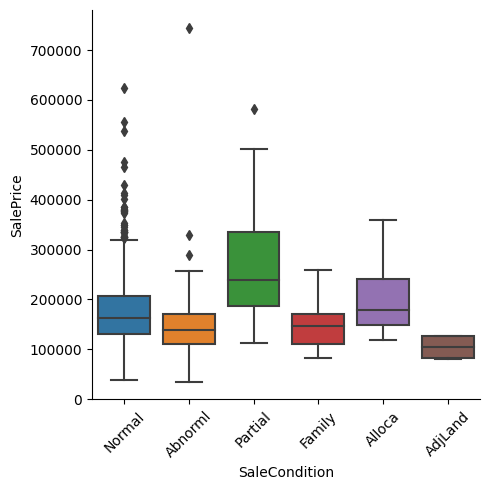

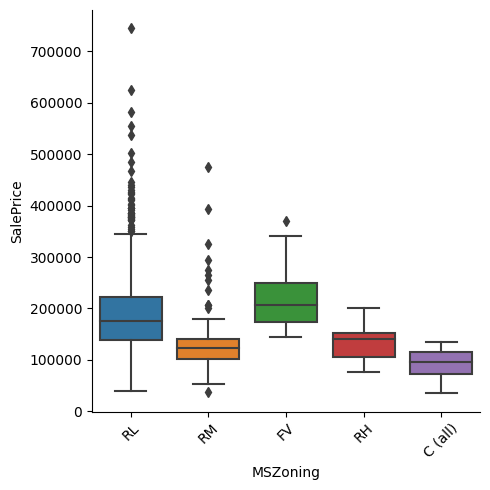

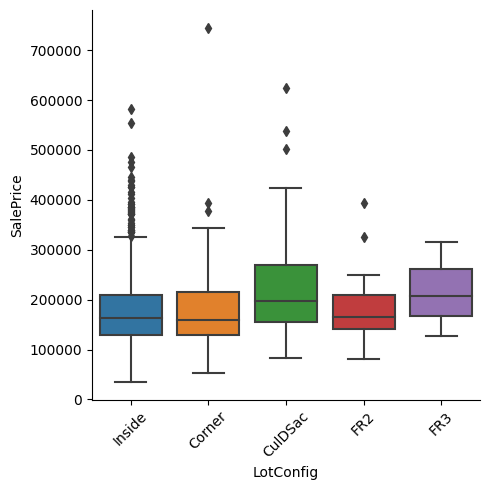

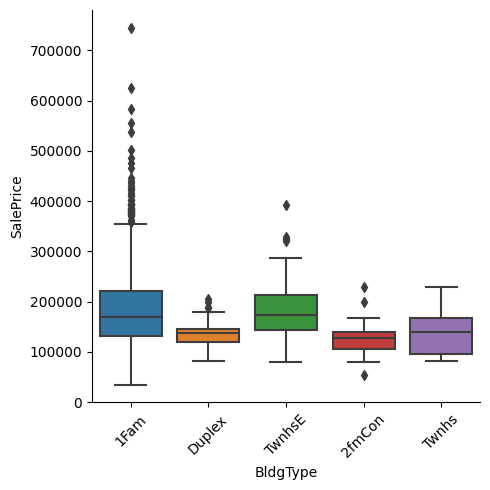

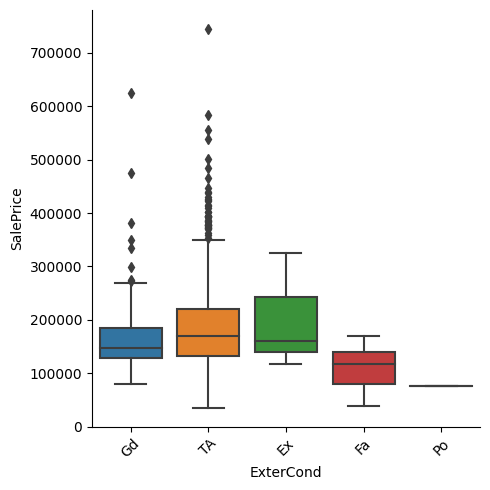

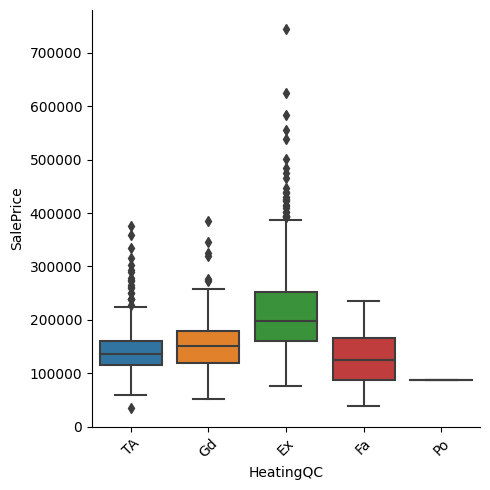

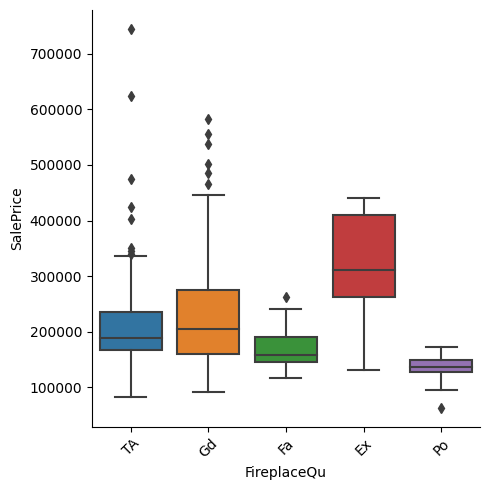

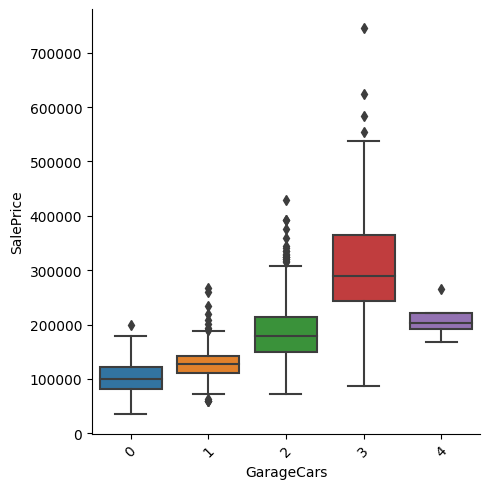

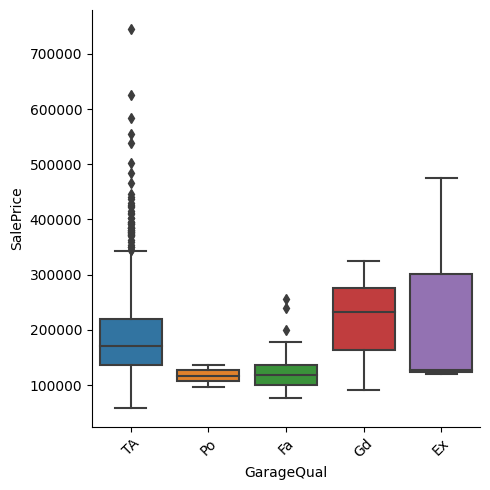

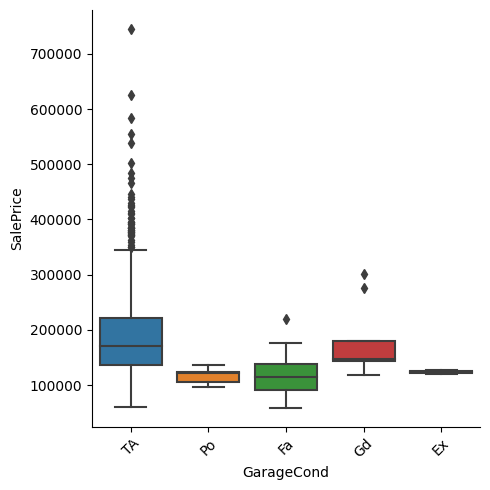

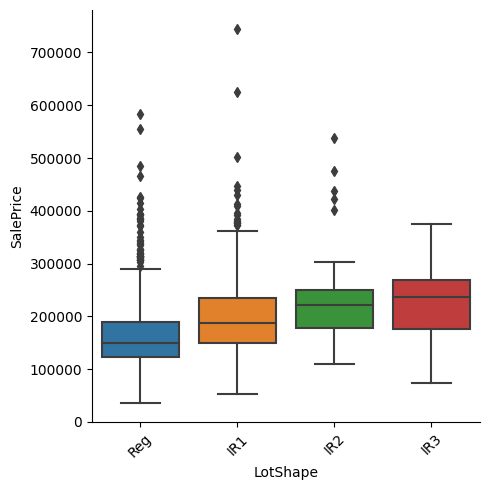

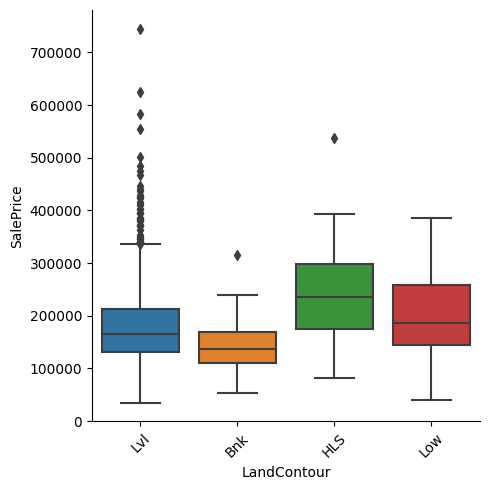

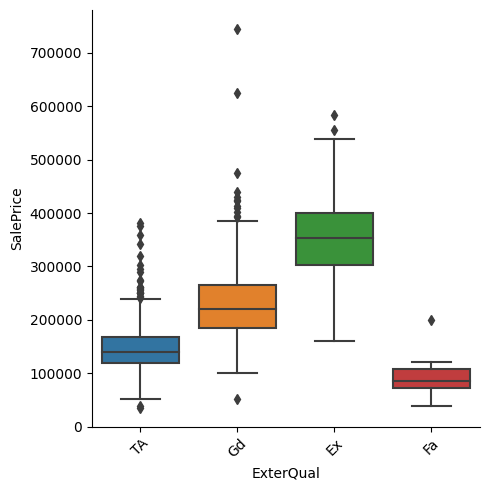

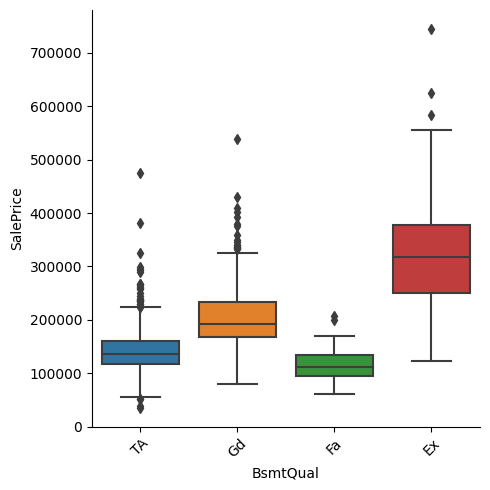

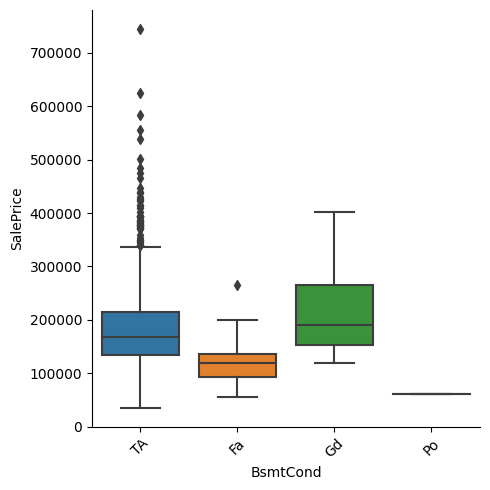

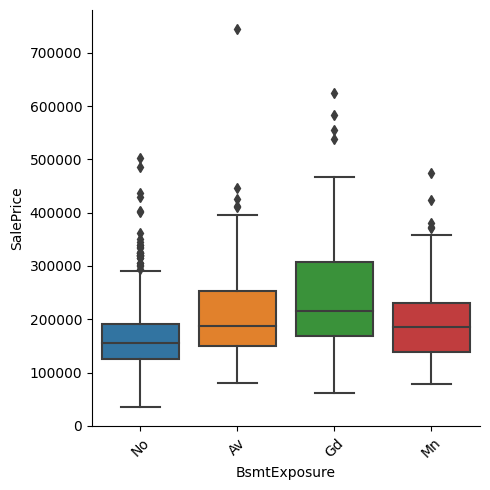

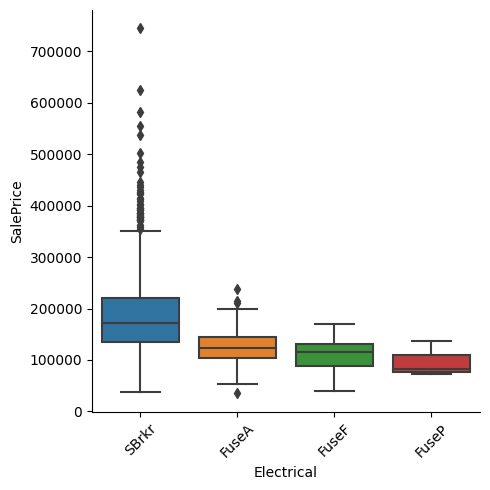

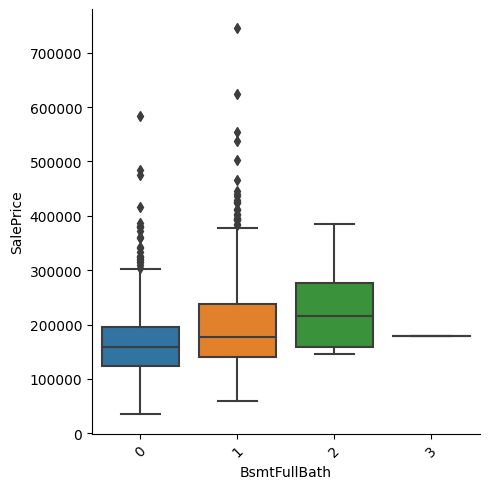

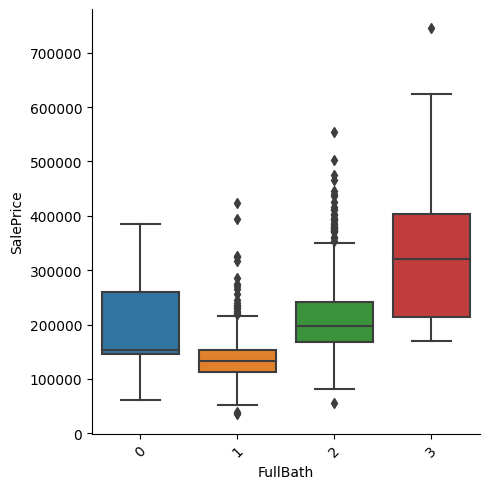

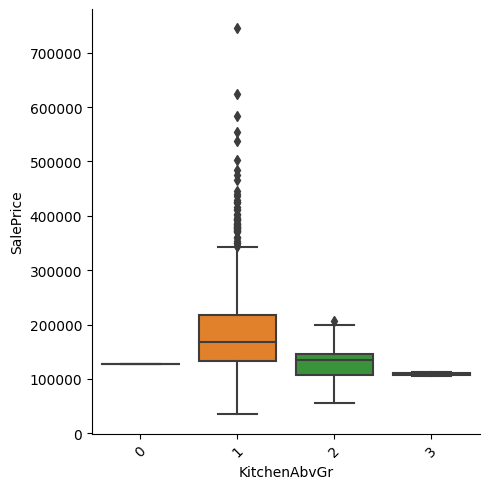

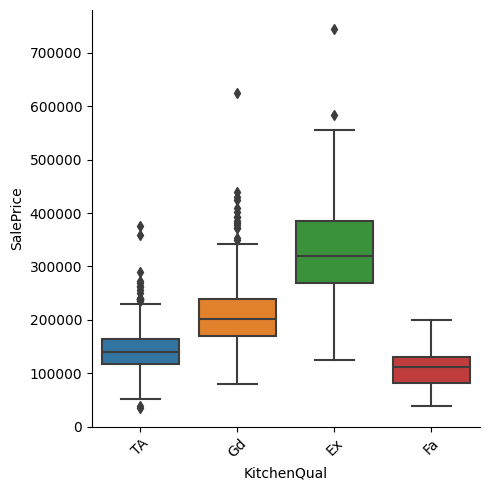

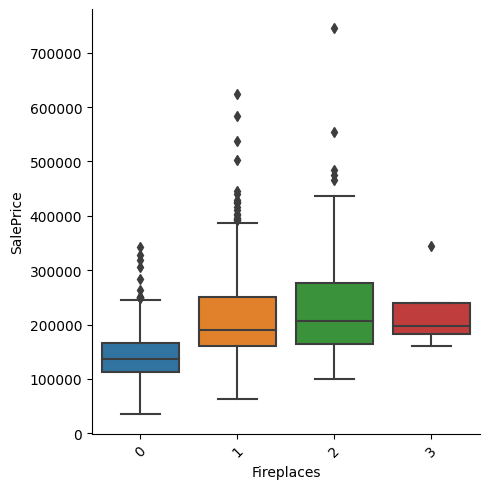

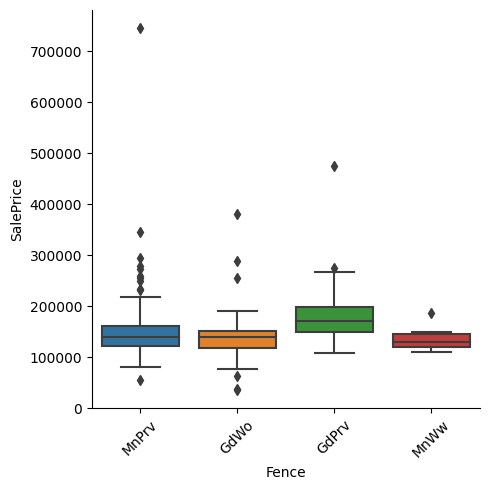

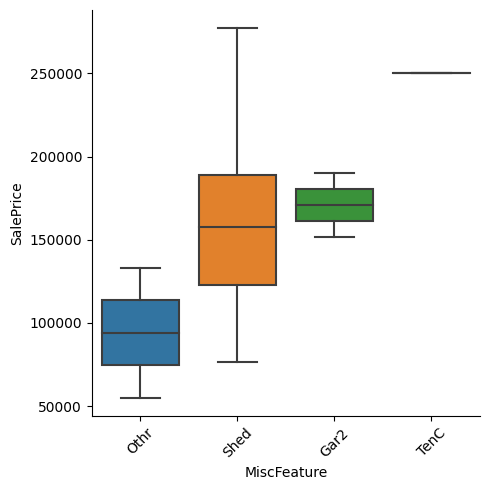

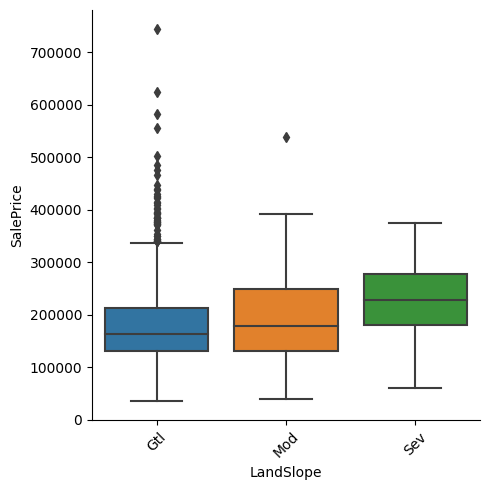

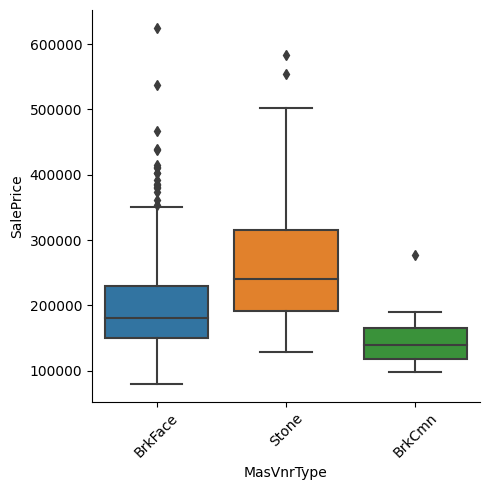

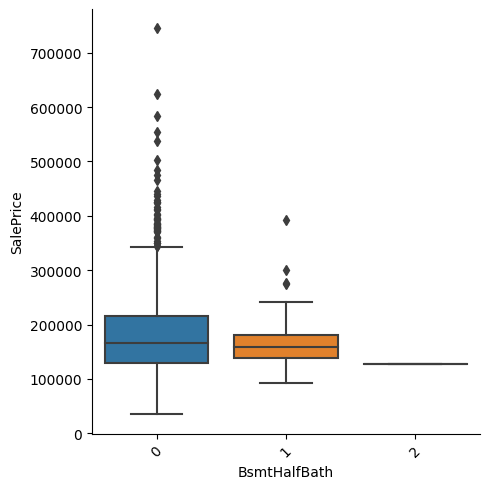

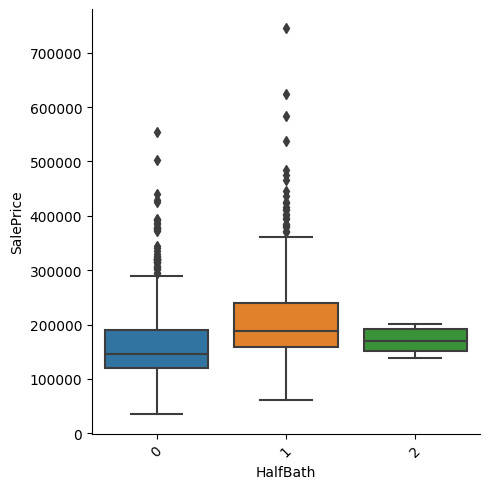

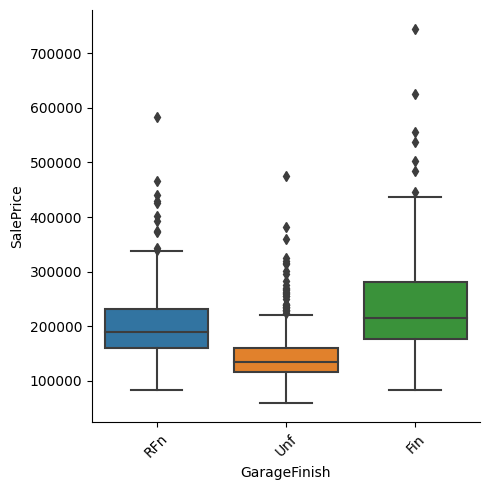

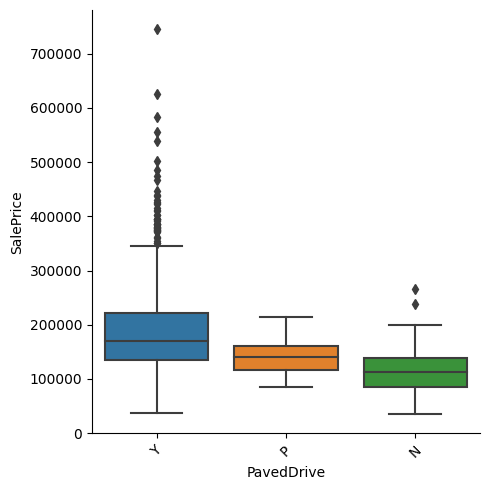

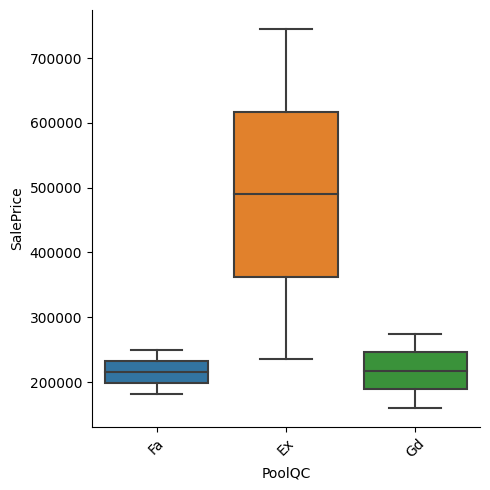

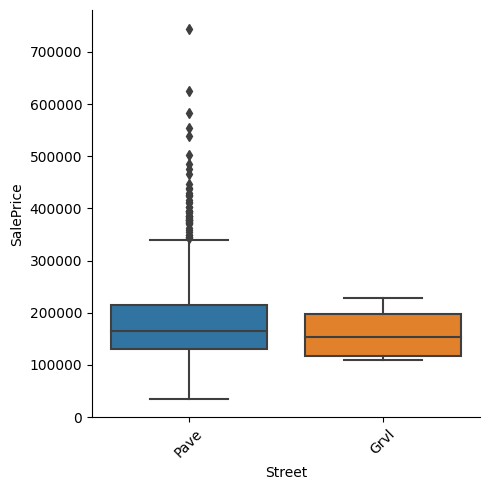

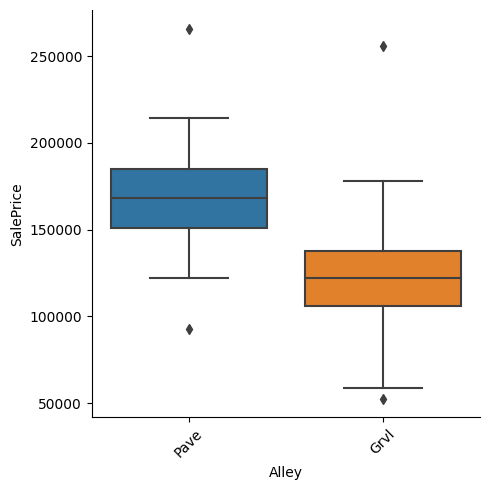

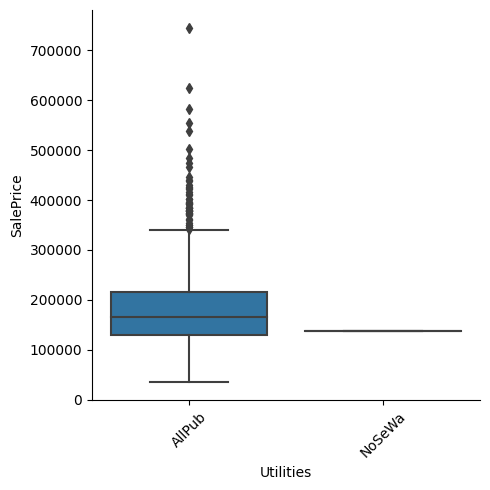

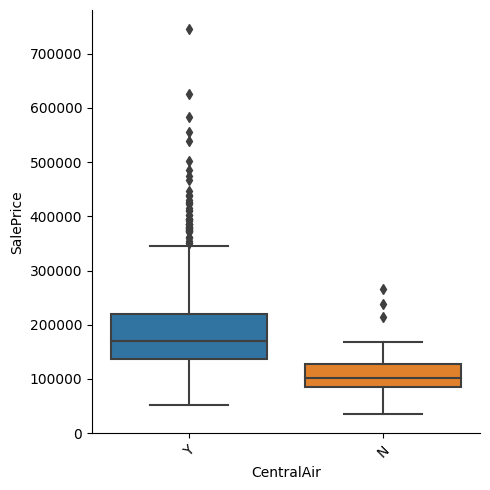

In [58]:
for feature in categorical_features_list:
    sns.catplot(x=feature,y="SalePrice", kind="box", data=train_data)
    plt.xticks(rotation=45)
    plt.tight_layout()


Above plots show how categorical varaibles influance Sale Price. Analysis of them i leave to You

# My approach on feature engenering : 
- `LotFrontage` 18% missing data, no strong relation with Sale Price = just impute missing values  with median
- `Alley`  93% missing data, examples with missing values tend to have higher mean SalePrice, there may be realation with Sale Price = impute `missing`, use OneHotEncoding
- `MasVnrType` 58% missing data, examples wiht missing values have lover mean Sale Price = impute NA with `missing`, use OneHotEncoding
- `BsmtQual` 2% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `BsmtCond` 2% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `BsmtExposure` 2% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `BsmtFinType1` 2% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `BsmtFinType2` 2% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use OneHotEncoding
- `TotalBsmtSF` 28 homes has no basement = Create binary feature `has_basement` and based on that create feature `basemenet_scaled` where i will transform data and scale them
- `BsmtFinSF1` feature has 32% of values that are 0. That means that 32% of homes may have no Type 1 finished space in basement. Create `has_finished1_basement` (1 if > 0, 0 if = 0) feature  and another one `finished1_basement_scaled`  where i will first transform data and then scale it
-  `BsmtFinSF2` feature has 88% of values that are 0. That means that 88% of homes may have no Type 2 finished space in basement. Create `has_finished2_basement` (1 if > 0, 0 if = 0) feature  and another one `finished2_basement_scaled` where i will first transform data and then scale it
- `FireplaceQu` 46% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding  create missing_fireplace scale  
- `GarageType` 5% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use OneHOtEncoding
- `GarageYrBlt`  5% missing data, examples with missing values have lower mean Sale Price = impute NA with `0` use OneHOtEncoding, create feature `is_missing_garage_yr` is year is NA
- `GarageFinish` 5% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use OneHOtEncoding
- `GarageQual` 5% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `GarageCond` 5% missing data, examples with missing values have lower mean Sale Price = impute NA with `missing` use Label Encoding
- `GarageCars` = impute NA with `missing` use OneHOtEncoding
- `Fence` 80% missing data, examples with missing values have higher mean Sale Price = impute NA with `missing` use Label Encoding
- `MiscFeature` 95% missing data, examples with missing values seem to have higher Sale Price = impute NA with `missing` use OneHOtEncoding and create `is_missing_additional_feature`
- `MasVnrArea`  0.3% missing data examples with missing values seem to have higher Sale Price but there is only 3 missing values = impute with `0`, since 57% of data are zeros, create another binary column `has_MasVnrArea` then create `MasVnrArea_scaled`
- `Electrical` one house have NaN vale that does not mean anything - impute with most frequent value, use OneHotEncoding
- `2ndFlrSF` 56% of homes have value of 0 = create feature `has_2floor` and  create `2floor_scaled` where i will paste values from orginal ferature and transforme them and scale
- `LowQualFinSF` 98% of data is zero, but it is very informatiove feature. Create bianry `has_low_qual`, then create `low_qual_scaled` then pase valus from ogrinal column, transform them and scale
- `BsmtFullBath`, `BsmtHalfBath`,`FullBath`,`HalfBath`,`KitchenAbvGr`, `KitchenQual` = OneHotEncoding 
- `TotRmsAbvGrd` = scale and transform
- `WoodDeckSF` = create binary missing column `has_deck` , then create new feature `deck_aera_scaled` , transform data and scale it
- `OpenPorchSF` = create binary missing column `has_porch` , then create new feature `porch_aera_scaled`, transform data and scale it
- `EnclosedPorch` = create binary missing column `has_endlosed_porch` , then create new feature `enclosed_porch_aera_scaled` , transform data and scale it
- `3SsnPorch` =  create binary missing column `has_3_porch` , then create new feature `3_porch_aera_scaled` , transform data and scale it
- `ScreenPorch` = create binary missing column `has_screen_porch` , then create new feature `screen_porch_aera_scaled` , transform data and scale it
- `MiscVal` =  create binary missing column `has_MiscVal` , then create new feature `MiscVal_scaled` , transform data and scale it

- Create additional features from year_features =` ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', "MoSold"]` then treat `YrSold` and `MoSold` as strings and as cattegorical features and use OneHotEncoding, missing values impute as 0  the rest i will keep but not scale

##### I am quite aware that afer all of this data modification i may overcomplicate model whitch will cause overfitting. Netherless i will try it because i am curious how that model will work out ( i can compre it's  performance with  me previous model Score: 0.13717). Next step is to conduct Feature Importance Analyzis and/or Feature Selection That's why the plan is to create many features without actualy carring for overfiting (whitch may not occure)

#####  I am also aware that feature preprocessing steps may givedifferentn results depending on algrythmo. Tree-based algoryhms like RF, XGBoost can handle raw data and adding feature like is_missing without scaling orginal one can work nicely. In otherhandLlinearMmodels or Neural Networks are sensitive to scaling, thats why it may be reasonable to drop ogrinal feature after scaling another basen on its values
 
.

## The approach :
- impute values
- onehot or ordinal encoding
- transform EVERY feature
- scale ONLY `scaled_features`
- Do some models search, then come back to Pipeline and modyfie it , accordingy to needs like scaling ale features , or drop unscaled orginal features.


### Data transformation pipelines

In [59]:
def create_new_features(dataframe):

    """Function will return dataframe with binary columns indicating absence of some features and new features that will be scaled
    also ther will be some time features used """
    
    create_based_if_0 = [
    'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2', 'MasVnrArea',
    '2ndFlrSF', 'LowQualFinSF', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal'
    ]
    create_based_if_NA = ["FireplaceQu","MiscFeature","PoolQC","Alley","GarageType"]

    for feature in create_based_if_0:
        dataframe[f"is_nonzero_{feature}"] = (dataframe[feature]>0).astype(int)
    for feature in create_based_if_NA:
        dataframe[f"is_missing_{feature}"] = dataframe[feature].isna().astype(int)

 
    create_features_to_scale= ["TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","2ndFlrSF","LowQualFinSF","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","MiscVal"]
    for feature in  create_features_to_scale:
        dataframe[f"scaled_{feature}"] = dataframe[feature]

    year_features = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']

    dataframe["Years_between_sell"] = (
    (dataframe["YrSold"] - dataframe["YearBuilt"].fillna(dataframe["YrSold"]))
    .apply(lambda x: max(x, 0)))

    dataframe["Time_between_renovation_and_sell"] = (
    (dataframe["YrSold"] - dataframe["YearRemodAdd"].fillna(dataframe["YrSold"]))
    .apply(lambda x: max(x, 0)))

    dataframe["Time_between_garage_construction_and_sell"] = (
    (dataframe["YrSold"] - dataframe["GarageYrBlt"].fillna(dataframe["YrSold"]))
    .apply(lambda x: max(x, 0)))

    
    
    return dataframe
    

    

In [60]:
def get_features_to_scale(dataframe):
    """based on new dataframe with freshly created features to scale, function will return all numerical features to scale"""
    categorical_features_list, numercial_features_list,year_features = prepare_numercial_categorical_date_feature(dataframe)

    features_to_scale = []
    for feature in dataframe.columns:
        if feature.startswith("scaled_"):
            features_to_scale.append(feature)

    # make sure that in numerical features that are not any features to slale (with prefis scaled_)
    numercial_features_list_preprocessed = []
    for feature in numercial_features_list:
        if not feature.startswith("scaled_"):
            numercial_features_list_preprocessed.append(feature)
            
            
    return numercial_features_list_preprocessed, features_to_scale
    

In [61]:
impute_with_mean = ["LotFrontage"]
impute_missing =["Alley","MasVnrType" ,"BsmtQual","BsmtCond", "BsmtExposure" , "BsmtFinType1" ,"BsmtFinType2" ,"FireplaceQu" , "GarageType" , "GarageFinish" 
                 ,"GarageCond","GarageCars" ,"Fence" ,"MiscFeature","PoolQC" ]

impute_zero = ["GarageYrBlt","MasVnrArea","BsmtHalfBath","BsmtFullBath"] # "BsmtHalfBath","BsmtFullBath" added
impute_most_frequent =["Electrical"]

mean_imputatation_transformer = Pipeline(steps=[
    ("impute_mean", SimpleImputer(strategy="mean"))
])


zero_imputation_transformer  = Pipeline(steps=[
    ("zero_imputation", SimpleImputer(strategy='constant', fill_value=0))
])


frequent_imputation_transformer  = Pipeline(steps=[
    ("frequent_imputation", SimpleImputer(strategy='most_frequent'))
])

 # Features to Encode
ordinal_features = ["BsmtQual","BsmtCond" ,"BsmtExposure" ,"BsmtFinType1" ,"FireplaceQu" ,"GarageQual","GarageCond" ,"Fence"]
onehot_features = ["Alley" ,"MasVnrType" ,"BsmtFinType2" ,"GarageType", "GarageFinish", "GarageCars" ,  "MiscFeature", "Electrical", "BsmtFullBath",
                  "BsmtHalfBath", "FullBath", "HalfBath", "KitchenAbvGr", "KitchenQual"]

# important note! OneHOtEncoding is not working when missing_imputation_transformer is places in pipeline alone, it has to be inside a ordinal or onehot transformer!

ordinal_transformer = Pipeline(steps=[
    ("impute_missing", SimpleImputer(strategy="constant", fill_value="missing")),
    ("ordinal", OrdinalEncoder())
])

onehot_transformer = Pipeline(steps=[
    ("missing_imputation", SimpleImputer(strategy='constant', fill_value='missing')),
    ("onehot",OneHotEncoder(handle_unknown="ignore"))
])


yeo_jonson_transformer = Pipeline(steps=[
    ("zero_imputation", SimpleImputer(strategy='constant', fill_value=0)),
    ("yeo",PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler()) 
])

target_transformer = Pipeline(steps=[
    ("yeo", PowerTransformer(method="yeo-johnson")),
    ("scaler", StandardScaler())  
])

In [62]:

def run_data_prepprocessing(dataframe):
    

    """ 
    The function is all you need to perform the data preprocessing steps as explained earlier (except scaling only the chosen features – more about that in the summary).
    The function takes a DataFrame as input and returns the transformed DataFrame and the pipeline itself (in case we need access to its attributes for any reason). 
    
    """

    if "SalePrice" in dataframe.columns:
        dataframe = dataframe.drop("SalePrice", axis=1, errors="ignore") ### 
    else:
        pass


    dataframe_with_new_features = create_new_features(dataframe) 

    numerical_features, features_to_scale = get_features_to_scale(dataframe_with_new_features)
    numerical_features.extend(features_to_scale) # combining numercial features and features to scale in one array

    one_hot = [var for var in dataframe_with_new_features.columns if dataframe_with_new_features[var].dtype == 'O'] # To make sure that all features are preprocessed
                                                                                                        # Unfortuantelly without that some features are strings
    for feature in ordinal_features: # Making sure that features are properly encoded
        if feature in one_hot:
            one_hot.remove(feature)


    for feature in numerical_features: # Making sure that features are properly encoded
        if feature in one_hot:
            one_hot.remove(feature)
    


    pipeline = Pipeline(steps=[
        ("preprocessor", ColumnTransformer(
            transformers=[
                ("mean_imp", mean_imputatation_transformer, impute_with_mean),
                ("zero_imp", zero_imputation_transformer, impute_zero),
                ("onehot", onehot_transformer, one_hot),
                ("ordinal", ordinal_transformer, ordinal_features),
                ("yeo", yeo_jonson_transformer, numerical_features),
            ],
            remainder=SimpleImputer(strategy="constant", fill_value=0)
        ))
    ])
    dataframe_transformed = pipeline.fit_transform(dataframe_with_new_features)
    dataframe_transformed_df= pd.DataFrame(dataframe_transformed)
    print("Final Transformed Data Shape with All Transformations:", dataframe_transformed_df.shape)
    return dataframe_transformed_df, pipeline

In [63]:
def run_validation_test_preprocessing(dataframe):
    """Function will run data preprocessing steps and return dataframe ready to by transformed by pipeline"""
    dataframe_with_new_features = create_new_features(dataframe) 

    return dataframe_with_new_features 


In [64]:
test_pipeline = train_data.copy()
test_pipeline

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,176432
1130,1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,135000
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000
860,861,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,189950


In [65]:
test_pipeline_transformed, pipeline = run_data_prepprocessing(test_pipeline)
test_pipeline_transformed


Final Transformed Data Shape with All Transformations: (1168, 297)


,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,70.0,1957.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,53.0,53.0
1,59.0,1993.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,15.0,16.0
2,67.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,58.0,0.0
3,60.0,1939.0,252.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,57.0,68.0
4,50.0,1924.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,78.0,2006.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
1164,65.0,1981.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,59.0,28.0
1165,60.0,1957.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,16.0,49.0
1166,55.0,1925.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,9.0,82.0


In [66]:
test_pipeline_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Columns: 297 entries, 0 to 296
dtypes: float64(297)
memory usage: 2.6 MB


In [67]:
test_pipeline_transformed.isna().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

## Data Transformation Summary
The goal was to:
- Transform and scale only specific features as described in "The Approach." (not quite done)
- Ensure the returned data was properly encoded and had no missing values.


# 2. Modeling

This part i will devide into:
1. Orginal Data preprocessing step
   - Shallow Learning model
   - Deep Learning model
2. Clever data preprocessing steps (modifications to previous approach)
    - Shallow Learning model
    - Deep Learning model
3. Experimentation

## 2.1 Orginal data preprocessing

In [68]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
254,255,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,145000
1066,1067,60,RL,59.0,7837,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,WD,Normal,178000
638,639,30,RL,67.0,8777,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,5,2008,WD,Normal,85000
799,800,50,RL,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2007,WD,Normal,175000
380,381,50,RL,50.0,5000,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,127000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,1096,20,RL,78.0,9317,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,176432
1130,1131,50,RL,65.0,7804,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,12,2009,WD,Normal,135000
1294,1295,20,RL,60.0,8172,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,115000
860,861,50,RL,55.0,7642,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,6,2007,WD,Normal,189950


In [69]:
y_train = train_data["SalePrice"]
X_train = train_data.drop("SalePrice", axis=1)

In [70]:
y_train.shape, X_train.shape

((1168,), (1168, 80))

In [71]:
validation_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
892,893,20,RL,70.0,8414,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal,154500
1105,1106,60,RL,98.0,12256,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,325000
413,414,30,RM,56.0,8960,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,115000
522,523,50,RM,50.0,5000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,159000
1036,1037,20,RL,89.0,12898,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,9,2009,WD,Normal,315500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,480,30,RM,50.0,5925,Pave,NaN,Reg,Bnk,AllPub,...,0,NaN,MnPrv,NaN,0,3,2007,WD,Alloca,89471
1361,1362,20,RL,124.0,16158,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,6,2009,WD,Normal,260000
802,803,60,RL,63.0,8199,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2008,WD,Normal,189000
651,652,70,RL,60.0,9084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,10,2009,WD,Normal,108000


In [72]:
y_val = validation_data["SalePrice"]
X_val = validation_data.drop("SalePrice", axis=1)

In [73]:
y_val.shape, X_val.shape

((292,), (292, 80))

### Data preprocessing

In [74]:
# Apply transforamtions to X_train data
X_train_transformed, pipeline = run_data_prepprocessing(X_train)
X_val_features = run_validation_test_preprocessing(X_val)
X_val_transformed = pd.DataFrame(pipeline.transform(X_val_features)) # i want that in DataFrame, it is easier to debud if needed

Final Transformed Data Shape with All Transformations: (1168, 297)


In [75]:
# Apply transformation to target
y_train_transormed = target_transformer.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_transformed = target_transformer.transform(y_val.values.reshape(-1,1)).ravel()

In [76]:
X_train_transformed.shape, y_train_transormed.shape

((1168, 297), (1168,))

In [77]:
X_val_transformed.shape, y_val_transformed.shape

((292, 297), (292,))

In [78]:
X_val_transformed

,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,296
0,70.0,1963.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,3.0,43.0
1,98.0,1994.0,362.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,15.0,16.0
2,56.0,1927.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,60.0,83.0
3,50.0,1950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,56.0,56.0
4,89.0,2008.0,70.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,50.0,1995.0,435.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,7.0,12.0
288,124.0,2005.0,16.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,4.0,4.0
289,63.0,2005.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,3.0
290,60.0,1940.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,59.0,69.0


In [79]:
X_val_transformed.isna().sum().loc[lambda x : x> 0]

Series([], dtype: int64)

### Shallow Learning models

In [80]:
# Models dictionary 
models = {
    "RF": RandomForestRegressor(random_state=42),
    "ElasticNet": ElasticNet(random_state=42,max_iter=10000),
    "LinReg": LinearRegression(),
    "XGB": XGBRegressor(random_state=42)
}



In [81]:
def cross_validate_models(X_train, y_train, models,cv):
    """Function will do cross-validation to choose the best model"""
    
    cv_ = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    models_results = {}
    models_results_right_scale = {}
    
    for name,model in models.items():
        results = cross_val_score(estimator=model,X=X_train, y=y_train, cv=cv_,scoring="neg_mean_squared_error", n_jobs=-1)
        
        rmse = np.sqrt(-results)
        rmse_mean = rmse.mean()
        
        models_results[name]=rmse_mean
    return models_results


In [82]:
# shallow_models_1 = cross_validate_models(X_train_transformed,y_train_transormed,models,5)

In [83]:

shallow_models_1_dict =   {
    'RF': 0.38314203007384917,
 'ElasticNet': 0.6551203571850815,
 'LinReg': 31868603.50313753,
 'XGB': 0.37872306064195893}


In [84]:
shallow_models_1_df = pd.DataFrame(shallow_models_1_dict,index=["Shallow results orginal data preprocessing"]).T
shallow_models_1_df.style.highlight_min(color="pink", axis=0)

,Shallow results orginal data preprocessing
RF,0.383142
ElasticNet,0.655120
LinReg,31868603.503138
XGB,0.378723


Best results is done by XGBoost, we wil stick to that algorythm

### RandomizedSearchCV

In [85]:
params = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'tree_method': ['hist']
}

In [86]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring={
    "rmse":make_scorer(rmse,greater_is_better=False)
}

rmse_scorer = make_scorer(rmse,greater_is_better=False)


In [87]:
def random_grid_with_validation(estimator, X_train, y_train, X_val, y_val,cv,paramas,random=True):

    model_cv_results = {}
    model_valdation_results = {}
    if random:
        model = RandomizedSearchCV(estimator=estimator,param_distributions=params,cv=cv,n_jobs=-1,random_state=42,refit="rmse",scoring=scoring)
    else:
        model = GridSearchCV(estimator=estimator,param_grid=params,cv=cv,n_jobs=-1,refit="rmse",scoring=scoring)

    model.fit(X_train,y_train)
    
    # Validate model
    best_model = model.best_estimator_
    predictions = best_model.predict(X_val)
    best_model_rmse = rmse(y_val,predictions)

    model_valdation_results={
        "RMSE_Validation" : best_model_rmse
    }   
    model_cv_results = {
        "best_params":model.best_params_,
        "Best_results": model.cv_results_
    }

    return model_valdation_results,model_cv_results


In [88]:
# xbg = XGBRegressor(random_state=42)
# xgb_random_val_results, xgb_random_cv_results = random_grid_with_validation(estimator=xbg, X_train=X_train_transformed, y_train=y_train_transormed, X_val=X_val_transformed, y_val=y_val_transformed,cv=5,paramas=params,random=True)

In [89]:
xgb_random_val_results_dict = {'RMSE': 0.36624324821538434}


In [90]:
xgb_random_cv_results_dict = {'best_params': {'tree_method': 'hist',
  'subsample': 0.6,
  'reg_lambda': 5,
  'n_estimators': 1000,
  'min_child_weight': 5,
  'max_depth': 9,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 1.0},
 'Best_results': {'mean_fit_time': np.array([ 1.88621597, 24.46871233,  4.39555912,  4.31238079,  0.66895962,
          2.41355495,  1.46914029,  5.35581975,  2.71292868,  1.97687225]),
  'std_fit_time': np.array([0.02622753, 0.93025441, 0.10180937, 0.07639942, 0.00889908,
         0.05154664, 0.00841452, 0.28985858, 0.03826405, 0.17372003]),
  'mean_score_time': np.array([0.06996522, 0.09929166, 0.0694005 , 0.06965303, 0.0680903 ,
         0.06904883, 0.06913214, 0.06969953, 0.06975718, 0.06087942]),
  'std_score_time': np.array([0.00116157, 0.00356887, 0.0021052 , 0.00228787, 0.0017259 ,
         0.00253045, 0.00150536, 0.00206525, 0.00237934, 0.00937297]),
  'param_tree_method': np.ma.masked_array(data=['hist', 'hist', 'hist', 'hist', 'hist', 'hist', 'hist',
                     'hist', 'hist', 'hist'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_subsample': np.ma.masked_array(data=[0.6, 1.0, 0.8, 1.0, 0.8, 0.8, 1.0, 0.6, 1.0, 0.8],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_reg_lambda': np.ma.masked_array(data=[1, 5, 10, 5, 1, 0, 0, 5, 0, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': np.ma.masked_array(data=[100, 1000, 1000, 1000, 100, 500, 100, 1000, 500, 300],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': np.ma.masked_array(data=[3, 3, 5, 7, 7, 5, 7, 5, 3, 7],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': np.ma.masked_array(data=[7, 12, 9, 7, 9, 7, 7, 9, 12, 12],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_learning_rate': np.ma.masked_array(data=[0.01, 0.01, 0.2, 0.1, 0.2, 0.1, 0.05, 0.1, 0.1, 0.05],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_gamma': np.ma.masked_array(data=[0, 0, 0.1, 0.3, 0.2, 0.1, 0, 0.1, 0.1, 0.3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_colsample_bytree': np.ma.masked_array(data=[0.8, 0.6, 1.0, 1.0, 0.6, 0.6, 0.8, 1.0, 0.8, 1.0],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'tree_method': 'hist',
    'subsample': 0.6,
    'reg_lambda': 1,
    'n_estimators': 100,
    'min_child_weight': 3,
    'max_depth': 7,
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.8},
   {'tree_method': 'hist',
    'subsample': 1.0,
    'reg_lambda': 5,
    'n_estimators': 1000,
    'min_child_weight': 3,
    'max_depth': 12,
    'learning_rate': 0.01,
    'gamma': 0,
    'colsample_bytree': 0.6},
   {'tree_method': 'hist',
    'subsample': 0.8,
    'reg_lambda': 10,
    'n_estimators': 1000,
    'min_child_weight': 5,
    'max_depth': 9,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'colsample_bytree': 1.0},
   {'tree_method': 'hist',
    'subsample': 1.0,
    'reg_lambda': 5,
    'n_estimators': 1000,
    'min_child_weight': 7,
    'max_depth': 7,
    'learning_rate': 0.1,
    'gamma': 0.3,
    'colsample_bytree': 1.0},
   {'tree_method': 'hist',
    'subsample': 0.8,
    'reg_lambda': 1,
    'n_estimators': 100,
    'min_child_weight': 7,
    'max_depth': 9,
    'learning_rate': 0.2,
    'gamma': 0.2,
    'colsample_bytree': 0.6},
   {'tree_method': 'hist',
    'subsample': 0.8,
    'reg_lambda': 0,
    'n_estimators': 500,
    'min_child_weight': 5,
    'max_depth': 7,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 0.6},
   {'tree_method': 'hist',
    'subsample': 1.0,
    'reg_lambda': 0,
    'n_estimators': 100,
    'min_child_weight': 7,
    'max_depth': 7,
    'learning_rate': 0.05,
    'gamma': 0,
    'colsample_bytree': 0.8},
   {'tree_method': 'hist',
    'subsample': 0.6,
    'reg_lambda': 5,
    'n_estimators': 1000,
    'min_child_weight': 5,
    'max_depth': 9,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 1.0},
   {'tree_method': 'hist',
    'subsample': 1.0,
    'reg_lambda': 0,
    'n_estimators': 500,
    'min_child_weight': 3,
    'max_depth': 12,
    'learning_rate': 0.1,
    'gamma': 0.1,
    'colsample_bytree': 0.8},
   {'tree_method': 'hist',
    'subsample': 0.8,
    'reg_lambda': 5,
    'n_estimators': 300,
    'min_child_weight': 7,
    'max_depth': 12,
    'learning_rate': 0.05,
    'gamma': 0.3,
    'colsample_bytree': 1.0}],
  'split0_test_rmse': np.array([-0.53449532, -0.34824535, -0.36114308, -0.33539712, -0.3322123 ,
         -0.31940401, -0.32343391, -0.32240147, -0.35732536, -0.32414646]),
  'split1_test_rmse': np.array([-0.53293698, -0.38664568, -0.38543682, -0.4037153 , -0.40021226,
         -0.37534322, -0.39700435, -0.37912263, -0.43165378, -0.38454964]),
  'split2_test_rmse': np.array([-0.65373301, -0.42591784, -0.41308126, -0.42843699, -0.40821149,
         -0.40600458, -0.41943469, -0.39073945, -0.44576424, -0.40419231]),
  'split3_test_rmse': np.array([-0.53322843, -0.34155804, -0.35688981, -0.35077415, -0.34291942,
         -0.3295813 , -0.33454684, -0.3279833 , -0.35999625, -0.32542713]),
  'split4_test_rmse': np.array([-0.47008511, -0.27907421, -0.28690517, -0.28295155, -0.28686329,
         -0.27960228, -0.27926228, -0.28295146, -0.30115608, -0.27745995]),
  'mean_test_rmse': np.array([-0.54489577, -0.35628822, -0.36069123, -0.36025502, -0.35408375,
         -0.34198708, -0.35073641, -0.34063966, -0.37917914, -0.3431551 ]),
  'std_test_rmse': np.array([0.05971514, 0.0490174 , 0.04199071, 0.05142218, 0.04512038,
         0.04419646, 0.05094361, 0.03952638, 0.05314195, 0.04567387]),
  'rank_test_rmse': np.array([10,  6,  8,  7,  5,  2,  4,  1,  9,  3], dtype=np.int32)}}

In [91]:
xgb_best_params_random = xgb_random_cv_results_dict["best_params"]
xgb_best_params_random

{'tree_method': 'hist',
 'subsample': 0.6,
 'reg_lambda': 5,
 'n_estimators': 1000,
 'min_child_weight': 5,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 1.0}

In [92]:
xgb_train_rmse = xgb_random_cv_results_dict["Best_results"]["mean_test_rmse"]
xgb_train_rmse = np.mean(xgb_train_rmse)*-1
xgb_train_rmse_dict = {
    "RMSE":xgb_train_rmse
}

In [93]:
xgb_results_shallow = pd.DataFrame([xgb_random_val_results_dict, xgb_train_rmse_dict], index=["Validation", "Train"])
xgb_results_shallow

,RMSE
Validation,0.366243
Train,0.373191


Model appers to generalize well to new data

###  Issue
GridSearchCV takes more than 12h to run even with accelerator. I wont be making it therefore.

### Training model on whole dataset, submition

In [94]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")


In [95]:
y = data["SalePrice"]
X = data.drop("SalePrice", axis=1)

In [96]:
y.shape, X.shape

((1460,), (1460, 80))

In [97]:
# Preprocessing
X_transformed, pipeline_orginal = run_data_prepprocessing(X)
y_transformed = target_transformer.fit_transform(y.values.reshape(-1,1)).ravel()


Final Transformed Data Shape with All Transformations: (1460, 299)


In [98]:
X_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 299 entries, 0 to 298
dtypes: float64(299)
memory usage: 3.3 MB


In [99]:
X_transformed.isna().sum().loc[lambda x: x > 0]

Series([], dtype: int64)

In [100]:
X_transformed.shape, y_transformed.shape

((1460, 299), (1460,))

In [101]:
set(X_transformed.columns) - set(X_train_transformed.columns)


{297, 298}

In [102]:
set(X_train_transformed.columns) - set(X_transformed.columns)

set()

In [103]:
X_transformed.isna().sum().loc[lambda x : x>0]

Series([], dtype: int64)

As we can see, there is a missmach is shapes of trainig data nad whole dataset. 
I am unable to locate the issue but i belive it is perfectly fine unless data to train model and to make predicitions have the same shape

In [104]:
best_params = {
    "n_estimators": 1000,
    "learning_rate": 0.1,
    "max_depth": 9,
    "min_child_weight": 5,
    "subsample": 0.6,
    "colsample_bytree": 1.0,
    "reg_lambda": 5,
    "gamma": 0.1,
    "tree_method": 'hist'
}


In [105]:
xgb_final_orginal_preprocessing = XGBRegressor(random_state=42,**best_params)
xgb_final_orginal_preprocessing.fit(X_transformed,y_transformed)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [106]:
test_orginal = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_orginal

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [107]:
test_new_features = run_validation_test_preprocessing(test_orginal)

# Apply transforamtions to test data

test_transformed = pd.DataFrame(pipeline_orginal.transform(test_new_features)) 



In [108]:
test_transformed.isna().sum().loc[lambda x : x>0]

Series([], dtype: int64)

In [109]:
test_transformed.shape

(1459, 299)

In [110]:
# predictions_scaled = xgb_final_orginal_preprocessing.predict(test_transformed)

In [111]:
# preds_normal = target_transformer.inverse_transform(predictions_scaled.reshape(-1,1))

In [112]:

# sample_submission_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
# sample_submission_df['SalePrice'] = preds_normal
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
# sample_submission_df.head()

### Summary - XGBoost Model on Preprocessed Dataset
In this part of the notebook, I used my custom data preprocessing steps. In my previous work (https://www.kaggle.com/code/jandyndor/house-prices-advanced-regression-techniques#Predicting-the-prices-of-a-House-based-on-the-given-features), where I simply converted data into numbers without much thought about the dataset, I achieved a score of **0.13717**.

This time, I am aiming for a better score because the data preprocessing steps were more tailored to the problem and, in my opinion, well thought out.

The XGBoost model using the original pipeline and data scored **0.13846**, which is slightly higher than my previous model and much worse than I expected.



## 2.2 Deep learning on orginal data preprocessing steps

To make sure everything works fine, i will repeat preprocessing steps

In [113]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
y = data["SalePrice"]
X = data.drop("SalePrice",axis=1)

In [114]:
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=42,test_size=0.2)

In [115]:
# PIPELINE


# Training
X_train_transformed_d , pipeline_orginal_deep = run_data_prepprocessing(X_train)
X_val_features = run_validation_test_preprocessing(X_val)
X_val_transformed_d = pd.DataFrame(pipeline_orginal_deep.transform(X_val_features))

# Testing
y_train_transformed_d = target_transformer.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_transformed_d = target_transformer.transform(y_val.values.reshape(-1,1)).ravel()

Final Transformed Data Shape with All Transformations: (1168, 297)


In [116]:
X_train_transformed_d.shape, X_val_transformed_d.shape

((1168, 297), (292, 297))

In [117]:
y_train_transformed_d.shape, y_val_transformed_d.shape

((1168,), (292,))

In [118]:
X_train_transformed_d.isna().sum().loc[lambda x : x>0], X_val_transformed_d.isna().sum().loc[lambda x : x>0]

(Series([], dtype: int64), Series([], dtype: int64))

In [119]:
def data_to_tensors(X_train, X_test, y_train, y_test):
    """Function will transform data to tensors and return them"""
    
    X_train_tensor = torch.tensor(X_train.values).float()
    X_test_tensor = torch.tensor(X_test.values).float()

    y_train_tensor = torch.tensor(y_train).float()
    y_test_tensor = torch.tensor(y_test).float()
    
    return X_train_tensor,X_test_tensor,y_train_tensor,y_test_tensor

In [120]:
def data_to_data_loader(X_train,X_test,y_train,y_test,batch_size):
    """Function will return data loader"""
    
    torch.manual_seed(42)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
  
    train_loader = DataLoader(train_dataset,batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    return train_loader, test_loader


In [121]:
def set_device():
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device 

In [122]:
# RSME 
class RMSELoss(nn.Module):
    def  __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,y_pred,y_true):
        return torch.sqrt(self.mse(y_pred,y_true))

In [123]:
class deep_model(nn.Module):
    
    def __init__(self, input_dim):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),  
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout for regularization
            nn.Linear(128, 64),  
            nn.ReLU(),
            nn.Linear(64, 32),  
            nn.ReLU(),
            nn.Linear(32, 1)  
        )
        
    def forward(self, x):
        return self.network(x)


In [124]:
# assume 297 shape of input
torch.manual_seed(42)

deep_ogrinal = deep_model(input_dim=297)
deep_ogrinal

deep_model(
  (network): Sequential(
    (0): Linear(in_features=297, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=32, bias=True)
    (6): ReLU()
    (7): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [125]:
loss_function = RMSELoss() # Pytorhc dos not have RMSE loos so i will create my own
optimizer = optim.Adam(params=deep_ogrinal.parameters(), lr=0.0001)

In [126]:
def train_deep_model(model, X_train, X_test, y_train, y_test, epochs, batch_size):
    device = set_device()

    model.to(device)
    
    X_train_transformed_tensor,X_val_transformed_tensor,y_train_transformed_tesnor,y_val_transformed_tesnor = data_to_tensors(X_train, X_test, y_train, y_test)
    train_loader, val_loader = data_to_data_loader(X_train_transformed_tensor,X_val_transformed_tensor,y_train_transformed_tesnor,y_val_transformed_tesnor,batch_size)

    model.train()

    for epoch in range(epochs):
        epoch_loss = 0
        
        for x_train, y_train in train_loader:
            x_train, y_train = x_train.to(device), y_train.to(device)

            y_train = y_train.unsqueeze(1)
            predictions = model(x_train)
            loss = loss_function(predictions,y_train)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch+1} loss is {epoch_loss}")
    
    return model # with this i will be able to inverse transforamtions of target variable


In [127]:
# deep_model_orginal = train_deep_model(deep_ogrinal, X_train_transformed_d, X_val_transformed_d, y_train_transformed_d, y_val_transformed_d, 3000, 32)
# Based on few expermients 3000 epochs is best choice 

In [128]:
def validate_deep_model(model, X_train, X_test, y_train, y_test, epochs, batch_size):
    device = set_device()

    model.to(device)
    model.eval()
    
    X_train_transformed_tensor,X_val_transformed_tensor,y_train_transformed_tesnor,y_val_transformed_tesnor = data_to_tensors(X_train, X_test, y_train, y_test)
    train_loader, val_loader = data_to_data_loader(X_train_transformed_tensor,X_val_transformed_tensor,y_train_transformed_tesnor,y_val_transformed_tesnor,batch_size)

    val_loss = 0
    with torch.inference_mode():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val = y_val.unsqueeze(1)

            preds = model(x_val)
            val_loss += loss_function(preds, y_val)
    print(f"Model loss on validation dataset is {val_loss}")



In [129]:
# deep_validation_orginal = validate_deep_model(deep_ogrinal, X_train_transformed_d, X_val_transformed_d, y_train_transformed_d, y_val_transformed_d, 2000, 32)

#  Model loss on validation dataset is 3.706602096557617


In [130]:
def predict_with_model(model,X_test):
    """Function will turn dataframe and make predictions, return numpy array"""
    device = set_device()
    X_test_tensor = torch.tensor(X_test.to_numpy()).float()
    X_test_tensor.to(device)
    
    model.eval()
    with torch.inference_mode():
        preds = model(X_test_tensor).cpu().numpy() # converting predictions to numpy so i can use inverse_transform
    return preds

In [131]:
test_orginal = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")


In [132]:
test_features_new = run_validation_test_preprocessing(test_orginal)
test_transformed_d = pd.DataFrame(pipeline_orginal_deep.transform(test_features_new))


In [133]:
test_transformed_d.isna().sum().loc[lambda x : x>0]

Series([], dtype: int64)

In [134]:
# predictions_transformed = predict_with_model(deep_ogrinal,test_transformed_d)

In [135]:
# predictions_orginal = target_transformer.inverse_transform(predictions_transformed.reshape(-1,1))


In [136]:
# sample_submission_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
# sample_submission_df['SalePrice'] = predictions_orginal
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
# sample_submission_df.head()

## Summarry Deep learning
This time deep learning model on orginal data scored **0.31196** whitch is not satisfying. 
Lower score for Deep Learning model might be foreseeable. XGBoost is best suited for tabular and small dataset like this and do not require so much data preprocessing setps.
Deep learning performs best wiht large and complex datasets. 

# 3.Clever Data Preprocessing
In previous work i rethinged all features adn cerated one based on my assumption. but i understand this might not be the best fearures for modeling and predicting puropse or machine learning algorythms mith cosnider preprocessed data noisy.

That's why in this short part i will try to makre my preprocessed data more "learningable" for mdoels

There are a few ways to do so:
- Filter methods : Corealtion Coefficient, Variance Threshold, Chs-Square test, ANOVA
- Wrapper Methods : Forward Selections, BAckward Elimination and Recursive Feature Elimination
- Some Embedded methods like Regularization

First of all let's look at corelation matrix

In [137]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [138]:
y = data["SalePrice"]
X = data.drop("SalePrice", axis=1)

# Preprocessing
X_t, pipeline_orginal = run_data_prepprocessing(X)
y_t = target_transformer.fit_transform(y.values.reshape(-1,1)).ravel()



Final Transformed Data Shape with All Transformations: (1460, 299)


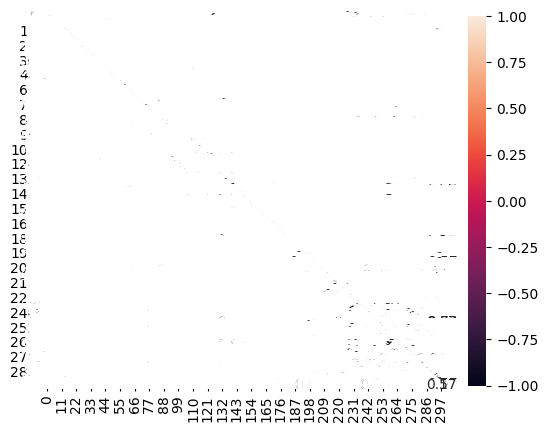

In [139]:
correltaion_matrix = X_t.corr()
sns.heatmap(correltaion_matrix, annot=True)
plt.show()

Keep in mind this is a corealtion matris of features **WITHOUT** target, is helpful for understanding relationships among the features themselves, but it does not directly provide insights into which features are most important for predicting the target.

For example we can see that there are some features highly correlated to each other,whitch may indicate that they are not needed because they carry same inforamtion.
We can also know that we have a lot of white in plot so most of the fearures are independent

In [140]:
whole_data_preprocessed = X_t.copy()
whole_data_preprocessed["SalePrice"] = y_t

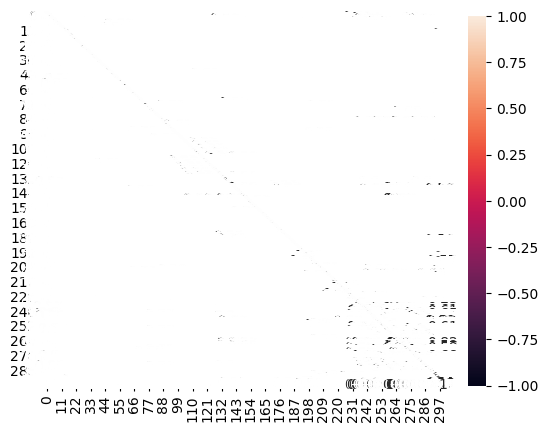

In [141]:
whole_data_preprocessed_corr = whole_data_preprocessed.corr()
sns.heatmap(whole_data_preprocessed_corr, annot=True)
plt.show()

We will check corelation to SalePrice

In [142]:
corr_with_target = whole_data_preprocessed.corr()["SalePrice"].sort_values(ascending=True)

In [143]:
features_with_top20_neg_corr=corr_with_target[:20]


In [144]:
features_with_top20_pos_corr=corr_with_target[300-21:-1]


In [145]:
features_names = pipeline_orginal.get_feature_names_out()


In [146]:
for index,value in features_with_top20_neg_corr.items():
    print(f"Feature {features_names[index]} has corealtion with target {value}")

Feature yeo__Years_between_sell has corealtion with target -0.6229037613926625
Feature onehot__ExterQual_TA has corealtion with target -0.5918966480793022
Feature ordinal__BsmtQual has corealtion with target -0.5856869793465534
Feature remainder__Time_between_renovation_and_sell has corealtion with target -0.5694652733754054
Feature onehot__KitchenQual_TA has corealtion with target -0.535686153408438
Feature remainder__is_missing_FireplaceQu has corealtion with target -0.5099446312770639
Feature ordinal__FireplaceQu has corealtion with target -0.4638511946446102
Feature onehot__GarageFinish_Unf has corealtion with target -0.43023855335580535
Feature remainder__Time_between_garage_construction_and_sell has corealtion with target -0.39349258968633843
Feature onehot__GarageType_Detchd has corealtion with target -0.3883934098409054
Feature onehot__MasVnrType_missing has corealtion with target -0.38718277213516367
Feature onehot__CentralAir_N has corealtion with target -0.359195817098214
Fe

In [147]:
for index,value in features_with_top20_pos_corr.items():
    print(f"Feature {features_names[index]} has corealtion with target {value}")

Feature onehot__GarageType_Attchd has corealtion with target 0.419583167354461
Feature zero_imp__MasVnrArea has corealtion with target 0.4214010806976592
Feature remainder__is_nonzero_OpenPorchSF has corealtion with target 0.44898458747477726
Feature yeo__OpenPorchSF has corealtion with target 0.45887033137837213
Feature yeo__scaled_OpenPorchSF has corealtion with target 0.45887033137837213
Feature onehot__HeatingQC_Ex has corealtion with target 0.46642162316075564
Feature remainder__Fireplaces has corealtion with target 0.48851805401410014
Feature onehot__ExterQual_Gd has corealtion with target 0.5099871699700336
Feature onehot__Foundation_PConc has corealtion with target 0.5299531931815586
Feature remainder__TotRmsAbvGrd has corealtion with target 0.5320198099147709
Feature remainder__YearRemodAdd has corealtion with target 0.5668841924348038
Feature remainder__YearBuilt has corealtion with target 0.5880368426180449
Feature remainder__FullBath has corealtion with target 0.59402239824

Based on above we can understand data better, and to be honest all of the above make sense

## Feature selection
In this section i choose to simply give a shot a RFE, RFECV exaclt whitch is recursive feature elimination with cross-validation to select features.


In [148]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [149]:
train_data, validation_data = train_test_split(data, test_size=0.2,random_state=42)


In [150]:
y_train = train_data["SalePrice"]
X_train = train_data.drop("SalePrice", axis=1)

y_val = validation_data["SalePrice"]
X_val = validation_data.drop("SalePrice", axis=1)


In [151]:
# Apply transforamtions to X_train data
X_train_transformed, pipeline = run_data_prepprocessing(X_train)
                                                       
X_val_features = run_validation_test_preprocessing(X_val)
X_val_transformed = pd.DataFrame(pipeline.transform(X_val_features)) 

# Apply transformation to target
y_train_transormed = target_transformer.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_val_transformed = target_transformer.transform(y_val.values.reshape(-1,1)).ravel()

Final Transformed Data Shape with All Transformations: (1168, 297)


Remember, to use RFECV with only test data set, this will prevent data leackage

### RandomizesSearchCV

In [152]:
params = {
    'n_estimators': [100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0, 1, 5, 10],
    'gamma': [0, 0.1, 0.2, 0.3],
    'tree_method': ['hist']
}

In [153]:
estimator = XGBRegressor(random_state=42)
rfecv = RFECV(estimator=estimator, step=1,cv=3,scoring=rmse_scorer,n_jobs=-1)
# rfecv.fit(X_train_transformed,y_train_transormed)

In [154]:
# print("Optimal number of features:", rfecv.n_features_)
# print("Selected features:", list(X_train_transformed.columns[rfecv.support_]))
# selected_features = list(X_train_transformed.columns[rfecv.support_])
# Optimal number of features: 34
# Selected features: [9, 19, 39, 58, 104, 169, 186, 188, 191, 196, 198, 219, 225, 227, 228, 229, 233, 234, 236, 237, 238, 239, 240, 244, 257, 263, 264, 265, 266, 267, 268, 269, 273, 295]


selected_features = [9, 19, 39, 58, 104, 169, 186, 188, 191, 196, 198, 219, 225, 227, 228, 229, 233, 234, 236, 237, 238, 239, 240, 244, 257, 263, 264, 265, 266, 267, 268, 269, 273, 295]

In [155]:
# Retrainig model on new version of parameters 
X_new_features_columns = X_train_transformed.columns[selected_features]
X_selected_features = X_train_transformed[X_new_features_columns]

Val_new_features_columns = X_val_transformed.columns[selected_features]
Val_selected_features = X_val_transformed[X_new_features_columns]


In [156]:
xgb_features = XGBRegressor(random_state=42)

In [157]:
# xgb_random_val_results, xgb_random_cv_results = random_grid_with_validation(estimator=xgb_features, X_train=X_selected_features, y_train=y_train_transormed, X_val=Val_selected_features, y_val=y_val_transformed,cv=5,paramas=params,random=True)

In [158]:
# xgb_random_val_results
# {'RMSE_Validation': 0.3709864917457855}

In [159]:
# xgb_random_cv_results

Model choose 34 features whitch is significantly less than orginal 297 but the performance is also lower. Unfortunatelly GridSearCV still takes a lot of time so i wont be able to compute it, but keep in mind that might change results ;) 

### Training XGBoost model on only selected features and whole dataset

In [160]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
y = data["SalePrice"]
X = data.drop("SalePrice", axis=1)

In [161]:
best_params = {'tree_method': 'hist',
  'subsample': 0.8,
  'reg_lambda': 0,
  'n_estimators': 500,
  'min_child_weight': 5,
  'max_depth': 7,
  'learning_rate': 0.1,
  'gamma': 0.1,
  'colsample_bytree': 0.6}

In [162]:
# Transformations
X_transformed_selected , pipeline2 = run_data_prepprocessing(X)
y_transformed_selected = target_transformer.fit_transform(y.values.reshape(-1,1)).ravel()

X_features_columns = X_transformed_selected.columns[selected_features]
X_selected_features = X_transformed_selected[X_features_columns]

Final Transformed Data Shape with All Transformations: (1460, 299)


In [163]:
X_selected_features.shape, y_transformed.shape

((1460, 34), (1460,))

In [164]:
xgb_selected_features_rfe = XGBRegressor(random_state=42, **best_params)
# xgb_selected_features_rfe.fit(X_selected_features,y_transformed)

In [165]:
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_with_features = run_validation_test_preprocessing(test_data)
test_transformed = pd.DataFrame(pipeline_orginal.transform(test_with_features)) 
test_transformed

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
0,80.0,1961.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,49.0,49.0
1,81.0,1958.0,108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,52.0,52.0
2,74.0,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,12.0,13.0
3,78.0,1998.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,12.0,12.0
4,43.0,1992.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,18.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,36.0,0.0
1455,21.0,1970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,36.0,36.0
1456,160.0,1960.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0,46.0
1457,62.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,14.0,0.0


In [166]:
test_columns = test_transformed.columns[selected_features]
test_selected_features = test_transformed[test_columns]
test_selected_features

,9,19,39,58,104,169,186,188,191,196,...,257,263,264,265,266,267,268,269,273,295
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.980706,1461.0,20.0,5.0,6.0,1961.0,1961.0,1.0,5.0,1.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.295845,1462.0,20.0,6.0,6.0,1958.0,1958.0,1.0,6.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.110286,1463.0,60.0,5.0,5.0,1997.0,1998.0,2.0,6.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.269999,1464.0,60.0,6.0,6.0,1998.0,1998.0,2.0,7.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.950337,1465.0,120.0,8.0,5.0,1992.0,1992.0,2.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.950337,2915.0,160.0,4.0,7.0,1970.0,1970.0,1.0,5.0,1.0
1455,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,-0.950337,2916.0,160.0,4.0,5.0,1970.0,1970.0,1.0,6.0,1.0
1456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.350496,2917.0,20.0,5.0,7.0,1960.0,1996.0,1.0,7.0,1.0
1457,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.799844,2918.0,85.0,5.0,5.0,1992.0,1992.0,1.0,6.0,1.0


In [167]:
# predictions_scaled = xgb_selected_features_rfe.predict(test_selected_features)

In [168]:
# predictions_normal = target_transformer.inverse_transform(predictions_scaled.reshape(-1,1))


In [169]:

# sample_submission_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
# sample_submission_df['SalePrice'] = predictions_normal
# sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
# sample_submission_df.head()

## Summary
This time model scored **0.14302**, whitch again is lower than my previous notebook on this topic.
That proves taht feature selection has influance on predictions and we have to be very carefull using that tool because we can get lower results

# Experimentation
**I strongly belive that runing feature preprocessing and feture engenering and feature selection is very important step. This time, it did not bring signifficant value, in fact it even lower model performance. In this kind of situations i remaind myself of very simple but kind of forgotten rule "Malchine Learning is experimentation". Not every time feature selection or data preprocessing will help, the beauty of this field is we can try a lot of thigns and then find the best approach. Having said that, i will try one more thing befre considering this notebook done. At first i decided to give a try to XGBoost feature importance method but then after a short consideration i tought that i already tried one method for feature selection bo why not explore something else? Let's build blender!**

Blending is a method to combine predictions from multiple machine learning models (base models) into a single, more robust prediction. It's a simplified form of stacking, another ensemble method.

## StackingRegressor - best results

In [170]:
data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
y = data["SalePrice"]
X = data.drop("SalePrice", axis=1)

In [171]:
# We are going to use corss-validation all the time to therre is no need to create sseparate validation set
X_transf, pipeline3 = run_data_prepprocessing(X)
y_transf = target_transformer.fit_transform(y.values.reshape(-1,1)).ravel()

Final Transformed Data Shape with All Transformations: (1460, 299)


In [172]:
shallow_models_1_df

,Shallow results orginal data preprocessing
RF,3.831420e-01
ElasticNet,6.551204e-01
LinReg,3.186860e+07
XGB,3.787231e-01


Based on my previous work we can decide whitch model to choose as base-models. 
- RandomForest
- XGBoost


In [173]:
base_models = [
    ("Random_Forest", RandomForestRegressor(random_state=42)),
    ("XGB", XGBRegressor(random_state=42,**best_params)),
]

meta_model = Ridge(random_state=42)

In [174]:
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=meta_model,cv=5,n_jobs=-1)

In [175]:
scores_stack = cross_val_score(estimator=stacking_regressor, X=X_transf, y=y_transf, cv=5, n_jobs=-1, scoring=rmse_scorer)

In [176]:
# Values are negative because my custom rmse_scorer has prameter greater_is_better=False so i can use it freally in cross_validation
scores_stack.mean() 
# -0.3233989413857309


-0.3233989413857309

In [177]:
stacking_regressor.fit(X_transf,y_transf)

StackingRegressor(cv=5,
                  estimators=[('Random_Forest',
                               RandomForestRegressor(random_state=42)),
                              ('XGB',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            i...
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None, min_child_weight=5,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                  final_estimator=Ridge(random_state=42), n_jobs=-1)

Predictig on Stacked regressor

In [178]:
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
test_with_features = run_validation_test_preprocessing(test_data)
test_transformed = pd.DataFrame(pipeline_orginal.transform(test_with_features)) 
test_transformed

,0,1,2,3,4,5,6,7,8,9,...,289,290,291,292,293,294,295,296,297,298
0,80.0,1961.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,49.0,49.0
1,81.0,1958.0,108.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,52.0,52.0
2,74.0,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,12.0,13.0
3,78.0,1998.0,20.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,12.0,12.0
4,43.0,1992.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,18.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,36.0,0.0
1455,21.0,1970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,36.0,36.0
1456,160.0,1960.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,10.0,46.0
1457,62.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,14.0,0.0


In [179]:
predictions_scaled = stacking_regressor.predict(test_transformed)

In [180]:
predictions_normal2 = target_transformer.inverse_transform(predictions_scaled.reshape(-1,1))


In [181]:
sample_submission_df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")
sample_submission_df['SalePrice'] = predictions_normal2
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,123839.066103
1,1462,152899.463309
2,1463,176938.489050
3,1464,194301.878917
4,1465,194705.119497


## Summary - Clever data preprocessing
This time StackedRegressor model achived score **0.13332** whitch is the best result even better than my previous notebook


# Summary 
This Notebook's goal was to carry out nice, deep Exploratory Data Analysis, Feature Engenering and Feature Preprocessing that will allow later models to learn and infrance well.
Despite the fact that my models did not achived the results i hoped for after data preprocessing steps (whitch i belive was well thought out) i still meanaged to beat the previous score.

Few take aways:
- It's extremly important to cary out EDA and understand dataset
- Pipelines are efficient and convinient way to preprocess data equally
- Just adding tons of features wont help to get better models
- There are way to improve models performance like Recursife Feature Elimination
- Very powerfull tool is Stacking whitch combines work of a few models into one

# Spotted issues

1. Unexpected Pipeline Results: When scaling and transforming were implemented as separate steps in a ColumnTransformer, the returned data:
    - Was not fully encoded.
    - Contained missing values.
    - Forced Solution: To resolve the issue, all features were scaled and transformed, not just the selected ones.
2. After transformations TEST dataset has 5 mising values that happens to be in columns `BsmtFullBaths` `BsmtHalfBat` and `GarageCars`. This occures only to test data.


In [182]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

This issue happed because as we can see in training data there was no missing values in columns `GarageCars`, `BsmtFullBath`, `BsmtHalfBath` and therefore columns were not preprocessed accordingly because Transformes did not learn the imputation strategy or some columns were supposed to be transformed by a few transformers what made confusin to tools i have been using. 


In [183]:
# Check which transformer handles each problematic column
features = pipeline_orginal.named_steps["preprocessor"].get_feature_names_out()

problematic_columns = features[[267, 268, 275]]

for column in problematic_columns:
    assigned_transformer = [
        (name, transformer)
        for name, transformer, columns in pipeline_orginal.named_steps["preprocessor"].transformers
        if column in columns
    ]
    # print(f"Column '{column}' is handled by: {assigned_transformer}")
# Column 'remainder__BsmtFullBath' is handled by: []
# Column 'remainder__BsmtHalfBath' is handled by: []
# Column 'remainder__GarageCars' is handled by: []

The code above has shown that these three columns have not been modified by any of my transformations, which is a bit surprising, to be honest.

Nevertheless, whether or not I fully understand how and why this issue occurred, it needs to be addressed. One approach is to set `remainder=SimpleImputer(strategy="constant", fill_value=0)` in the pipeline to handle these columns and any others that might have been overlooked. Alternatively, I could explicitly fill these three problematic columns with 0 after the pipeline transformation.

I chose to set the remainder as a SimpleImputer with a fill value of 0.

Later on, I found that this approach significantly improved the performance of the deep learning model! It turned out that I had been missing some features or not transforming them properly. Before setting the remainder to fill values with 0, the deep learning model had an RMSE of 36 and couldn’t go lower. Now, with this adjustment, the RMSE is around 7.